# Neural Layer Apoptosis Experiment

This notebook implements layer-level apoptosis and neurogenesis in a character-level transformer,
where deep (output-adjacent) layers decay while shallow (input-adjacent) layers are born.

## Architecture Overview
- 6-layer decoder-only transformer
- Death zone: layers 5-6 (closest to output)
- Birth zone: layers 1-2 (closest to input)  
- Stable core: layers 3-4 (never die)
- ~500K parameters, 128 dim, 4 heads, 128 context window

In [1]:
# Imports and Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple
from pathlib import Path
import urllib.request
from tqdm import tqdm
import math
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration (prioritize MPS for Apple Silicon)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: CUDA ({torch.cuda.get_device_name(0)})")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using device: MPS (Apple Silicon GPU)")
    print(f"Expected speedup: 5-10x faster than CPU on M2 Max")
else:
    device = torch.device('cpu')
    print(f"Using device: CPU")

# Paths
DATA_DIR = Path('data')
CHECKPOINT_DIR = Path('checkpoints')
LOG_DIR = Path('logs')

DATA_DIR.mkdir(exist_ok=True)
CHECKPOINT_DIR.mkdir(exist_ok=True)
LOG_DIR.mkdir(exist_ok=True)

Using device: MPS (Apple Silicon GPU)
Expected speedup: 5-10x faster than CPU on M2 Max


## Section 1: Core Components

### 1.1 Character Tokenizer

In [2]:
class CharTokenizer:
    """Simple character-level tokenizer for ASCII subset."""
    
    def __init__(self, text: str = None):
        if text:
            chars = sorted(list(set(text)))
            self.char_to_idx = {ch: i for i, ch in enumerate(chars)}
            self.idx_to_char = {i: ch for i, ch in enumerate(chars)}
        else:
            # Default ASCII subset
            chars = list(range(32, 127))  # Printable ASCII
            self.char_to_idx = {chr(i): i - 32 for i in chars}
            self.idx_to_char = {i - 32: chr(i) for i in chars}
    
    @property
    def vocab_size(self) -> int:
        return len(self.char_to_idx)
    
    def encode(self, text: str) -> List[int]:
        return [self.char_to_idx.get(ch, 0) for ch in text]
    
    def decode(self, indices: List[int]) -> str:
        return ''.join([self.idx_to_char.get(i, '?') for i in indices])

# Test tokenizer
tokenizer = CharTokenizer()
test_text = "Hello, World!"
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Original: {test_text}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")

Vocab size: 95
Original: Hello, World!
Encoded: [40, 69, 76, 76, 79, 12, 0, 55, 79, 82, 76, 68, 1]
Decoded: Hello, World!


### 1.2 Senescence Metadata

In [3]:
@dataclass
class SenescenceMetadata:
    """Metadata tracking layer lifecycle and senescence."""
    age: int = 0                           # Steps since birth
    vitality: float = 1.0                  # [0.0, 1.0] health metric
    influence_weight: float = 1.0          # [0.0, 1.0] scales layer output
    temperature: float = 1.0               # Attention temperature
    layer_zone: str = "stable"             # "death", "birth", or "stable"
    dropout_rate: float = 0.1              # Dynamic dropout
    learning_rate_scale: float = 1.0       # LR multiplier
    
    def update(self, max_lifespan: int, maturation_period: int, 
               base_temp: float, temp_range: float,
               base_dropout: float, dropout_range: float,
               plasticity_ceiling: float = 0.7):
        """Update vitality and derived parameters based on age and zone."""
        self.age += 1
        
        if self.layer_zone == "death":
            # Deep layers: vitality decays to zero
            self.vitality = max(0.0, 1.0 - (self.age / max_lifespan))
            self.influence_weight = self.vitality
            # Old layers: low temperature (exploit), low dropout (preserve)
            self.temperature = base_temp - (self.vitality * temp_range)
            self.dropout_rate = base_dropout + (1.0 - self.vitality) * dropout_range
            self.learning_rate_scale = 0.5 + 0.5 * self.vitality
            
        elif self.layer_zone == "birth":
            # Shallow layers: vitality grows from zero
            self.vitality = min(1.0, self.age / maturation_period)
            self.influence_weight = self.vitality * plasticity_ceiling
            # Young layers: high temperature (explore), high dropout (prevent crystallization)
            self.temperature = base_temp + (1.0 - self.vitality) * temp_range
            self.dropout_rate = base_dropout + (1.0 - self.vitality) * dropout_range
            self.learning_rate_scale = 1.0 + 0.5 * (1.0 - self.vitality)
            
        else:  # stable core
            # Stable layers maintain full vitality
            self.vitality = 1.0
            self.influence_weight = 1.0
            self.temperature = base_temp
            self.dropout_rate = base_dropout
            self.learning_rate_scale = 1.0

# Test senescence update
meta = SenescenceMetadata(layer_zone="death")
print(f"Initial: vitality={meta.vitality:.3f}, influence={meta.influence_weight:.3f}")
for i in range(500):
    meta.update(max_lifespan=1000, maturation_period=500, 
                base_temp=1.0, temp_range=0.5,
                base_dropout=0.1, dropout_range=0.3)
print(f"After 500 steps: vitality={meta.vitality:.3f}, influence={meta.influence_weight:.3f}, temp={meta.temperature:.3f}")

Initial: vitality=1.000, influence=1.000
After 500 steps: vitality=0.500, influence=0.500, temp=0.750


### 1.3 Transformer Components

In [4]:
class SenescenceTransformerBlock(nn.Module):
    """Transformer block with senescence-aware attention and dynamics."""
    
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        
        # Multi-head self-attention
        self.attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True
        )
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout (will be dynamically adjusted)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None, 
                temperature: float = 1.0) -> torch.Tensor:
        """Forward pass with temperature-scaled attention.
        
        Args:
            x: Input tensor (batch, seq_len, d_model)
            mask: Causal attention mask
            temperature: Scales attention logits (higher = more uniform, lower = sharper)
        """
        # Self-attention with residual
        attn_out, _ = self.attention(x, x, x, attn_mask=mask, need_weights=False)
        
        # Apply temperature scaling (approximation: scale output instead of logits)
        if temperature != 1.0:
            attn_out = attn_out / temperature
        
        x = self.norm1(x + self.dropout(attn_out))
        
        # Feed-forward with residual
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x


class ApoptoticTransformer(nn.Module):
    """Decoder-only transformer with layer-level apoptosis."""
    
    def __init__(self, vocab_size: int, d_model: int = 128, n_heads: int = 4,
                 n_layers: int = 6, max_seq_len: int = 128, dropout: float = 0.1,
                 enable_apoptosis: bool = True):
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.enable_apoptosis = enable_apoptosis
        self.max_seq_len = max_seq_len
        
        # Token and position embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            SenescenceTransformerBlock(d_model, n_heads, dropout)
            for _ in range(n_layers)
        ])
        
        # Output projection
        self.output_proj = nn.Linear(d_model, vocab_size)
        
        # Senescence metadata for each layer
        self.senescence = self._initialize_senescence()
        
        # Create causal mask
        self.register_buffer('causal_mask', 
                           torch.triu(torch.ones(max_seq_len, max_seq_len) * float('-inf'), diagonal=1))
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _initialize_senescence(self) -> List[SenescenceMetadata]:
        """Initialize senescence metadata based on layer zones."""
        metadata = []
        for i in range(self.n_layers):
            if i < 2:  # Layers 0-1: birth zone
                zone = "birth"
                vitality = 0.5  # Start partially developed
            elif i >= 4:  # Layers 4-5: death zone
                zone = "death"
                vitality = 1.0  # Start fully vital
            else:  # Layers 2-3: stable core
                zone = "stable"
                vitality = 1.0
            
            meta = SenescenceMetadata(
                layer_zone=zone,
                vitality=vitality,
                influence_weight=vitality if zone == "birth" else 1.0
            )
            metadata.append(meta)
        return metadata
    
    def _init_weights(self, module):
        """Initialize weights using Xavier/He initialization."""
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the transformer.
        
        Args:
            x: Input token indices (batch, seq_len)
            
        Returns:
            Logits (batch, seq_len, vocab_size)
        """
        batch_size, seq_len = x.shape
        
        # Embeddings
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)
        x = self.token_embedding(x) + self.position_embedding(positions)
        
        # Get causal mask for this sequence length
        mask = self.causal_mask[:seq_len, :seq_len]
        
        # Pass through transformer blocks with senescence scaling
        for i, block in enumerate(self.blocks):
            meta = self.senescence[i]
            
            # Forward pass with temperature
            x = block(x, mask=mask, temperature=meta.temperature)
            
            # Scale by influence weight (gradual death/birth)
            if self.enable_apoptosis:
                x = x * meta.influence_weight
        
        # Output projection
        logits = self.output_proj(x)
        return logits
    
    def get_num_params(self) -> int:
        """Count total parameters."""
        return sum(p.numel() for p in self.parameters())
    
    def get_effective_params(self) -> int:
        """Count effective parameters weighted by influence."""
        total = 0
        # Embeddings and output always count
        total += sum(p.numel() for p in self.token_embedding.parameters())
        total += sum(p.numel() for p in self.position_embedding.parameters())
        total += sum(p.numel() for p in self.output_proj.parameters())
        
        # Transformer blocks weighted by influence
        for i, block in enumerate(self.blocks):
            block_params = sum(p.numel() for p in block.parameters())
            total += int(block_params * self.senescence[i].influence_weight)
        
        return total

# Test model
model = ApoptoticTransformer(vocab_size=95, enable_apoptosis=True).to(device)
print(f"Total parameters: {model.get_num_params():,}")
print(f"Effective parameters: {model.get_effective_params():,}")

# Test forward pass
test_input = torch.randint(0, 95, (2, 64)).to(device)
test_output = model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")

Total parameters: 1,230,431
Effective parameters: 1,032,159
Input shape: torch.Size([2, 64])
Output shape: torch.Size([2, 64, 95])


## Section 2: Apoptosis Mechanics

In [5]:
class ApoptosisManager:
    """Manages layer death and birth events."""
    
    def __init__(self, model: ApoptoticTransformer,
                 max_lifespan: int = 3000,
                 maturation_period: int = 750,
                 apoptosis_interval: int = 500,
                 vitality_threshold: float = 0.1,
                 base_temp: float = 1.0,
                 temp_range: float = 0.5,
                 base_dropout: float = 0.1,
                 dropout_range: float = 0.3,
                 plasticity_ceiling: float = 0.5,
                 mutation_strength: float = 0.2):
        self.model = model
        self.max_lifespan = max_lifespan
        self.maturation_period = maturation_period
        self.apoptosis_interval = apoptosis_interval
        self.vitality_threshold = vitality_threshold
        self.base_temp = base_temp
        self.temp_range = temp_range
        self.base_dropout = base_dropout
        self.dropout_range = dropout_range
        self.plasticity_ceiling = plasticity_ceiling
        self.mutation_strength = mutation_strength
        self.step_count = 0
        self.apoptosis_events = []  # Track (step, layer_idx) for all deaths
    
    def step(self) -> bool:
        """Update senescence and check for apoptosis. Returns True if apoptosis occurred."""
        self.step_count += 1
        
        # Update all layer senescence
        for meta in self.model.senescence:
            meta.update(
                max_lifespan=self.max_lifespan,
                maturation_period=self.maturation_period,
                base_temp=self.base_temp,
                temp_range=self.temp_range,
                base_dropout=self.base_dropout,
                dropout_range=self.dropout_range,
                plasticity_ceiling=self.plasticity_ceiling
            )
        
        # Check for apoptosis every interval
        if self.step_count % self.apoptosis_interval == 0:
            return self.trigger_apoptosis()
        
        return False
    
    def trigger_apoptosis(self) -> bool:
        """Check for dying layers and trigger birth. Returns True if apoptosis occurred."""
        apoptosis_occurred = False
        
        # Find layers below vitality threshold in death zone
        for i, meta in enumerate(self.model.senescence):
            if meta.layer_zone == "death" and meta.vitality < self.vitality_threshold:
                print(f"\n[Apoptosis Event @ step {self.step_count}] Layer {i} dying (vitality={meta.vitality:.3f})")
                self.kill_and_rebirth_layer(i)
                self.apoptosis_events.append((self.step_count, i))
                apoptosis_occurred = True
        
        return apoptosis_occurred
    
    def kill_and_rebirth_layer(self, dying_layer_idx: int):
        """Kill a layer and birth a new one via evolutionary mutation."""
        # Find healthy layers to sample from (vitality > 0.5)
        healthy_layers = [
            i for i, meta in enumerate(self.model.senescence)
            if meta.vitality > 0.5
        ]
        
        if not healthy_layers:
            print("Warning: No healthy layers to inherit from, using random initialization")
            self._random_init_layer(dying_layer_idx)
        else:
            parent_idx = random.choice(healthy_layers)
            print(f"  → Inheriting from layer {parent_idx} with mutation")
            self._mutate_layer_from_parent(dying_layer_idx, parent_idx)
        
        # Reset senescence to birth zone
        self.model.senescence[dying_layer_idx] = SenescenceMetadata(
            age=0,
            vitality=0.0,
            influence_weight=0.0,
            layer_zone="birth"
        )
    
    def _mutate_layer_from_parent(self, child_idx: int, parent_idx: int):
        """Initialize child layer by mutating parent's weights."""
        child_block = self.model.blocks[child_idx]
        parent_block = self.model.blocks[parent_idx]
        
        with torch.no_grad():
            for child_param, parent_param in zip(child_block.parameters(), parent_block.parameters()):
                # Copy parent weights and add Gaussian noise
                noise = torch.randn_like(parent_param) * self.mutation_strength
                child_param.copy_(parent_param + noise)
    
    def _random_init_layer(self, layer_idx: int):
        """Randomly initialize a layer."""
        block = self.model.blocks[layer_idx]
        block.apply(self.model._init_weights)
    
    def get_vitality_snapshot(self) -> List[float]:
        """Get current vitality for all layers."""
        return [meta.vitality for meta in self.model.senescence]
    
    def get_influence_snapshot(self) -> List[float]:
        """Get current influence weights for all layers."""
        return [meta.influence_weight for meta in self.model.senescence]

# Test apoptosis manager
model = ApoptoticTransformer(vocab_size=95, enable_apoptosis=True).to(device)
apoptosis_mgr = ApoptosisManager(model, max_lifespan=1000, apoptosis_interval=100)

print("Initial vitality:", apoptosis_mgr.get_vitality_snapshot())
for i in range(150):
    apoptosis_mgr.step()
    if i % 25 == 0:
        print(f"After {i} steps:", apoptosis_mgr.get_vitality_snapshot())        
print("After 150 steps:", apoptosis_mgr.get_vitality_snapshot())

Initial vitality: [0.5, 0.5, 1.0, 1.0, 1.0, 1.0]
After 0 steps: [0.0013333333333333333, 0.0013333333333333333, 1.0, 1.0, 0.999, 0.999]
After 25 steps: [0.034666666666666665, 0.034666666666666665, 1.0, 1.0, 0.974, 0.974]
After 50 steps: [0.068, 0.068, 1.0, 1.0, 0.949, 0.949]
After 75 steps: [0.10133333333333333, 0.10133333333333333, 1.0, 1.0, 0.924, 0.924]
After 100 steps: [0.13466666666666666, 0.13466666666666666, 1.0, 1.0, 0.899, 0.899]
After 125 steps: [0.168, 0.168, 1.0, 1.0, 0.874, 0.874]
After 150 steps: [0.2, 0.2, 1.0, 1.0, 0.85, 0.85]


## Section 3: Training Infrastructure

### 3.1 Dataset

In [6]:
class CharDataset(Dataset):
    """Character-level dataset with sliding window."""
    
    def __init__(self, text: str, tokenizer: CharTokenizer, seq_len: int = 128):
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
    
    def __len__(self) -> int:
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[idx:idx + self.seq_len]
        y = self.data[idx + 1:idx + self.seq_len + 1]
        return x, y


def download_tinyshakespeare() -> str:
    """Download TinyShakespeare dataset."""
    path = DATA_DIR / 'shakespeare.txt'
    if not path.exists():
        print("Downloading TinyShakespeare...")
        url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        urllib.request.urlretrieve(url, path)
        print(f"Downloaded to {path}")
    return path.read_text()


def download_python_code() -> str:
    """Create a simple Python code corpus for domain shift."""
    path = DATA_DIR / 'python_code.txt'
    if not path.exists():
        # For now, create a synthetic Python corpus
        # In a real experiment, you'd download actual Python code
        python_code = '''
def fibonacci(n):
    if n <= 1:
        return n
    return fibonacci(n-1) + fibonacci(n-2)

class DataProcessor:
    def __init__(self, data):
        self.data = data
    
    def process(self):
        result = []
        for item in self.data:
            if isinstance(item, str):
                result.append(item.upper())
        return result

import numpy as np
import torch

def train_model(model, data, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        for batch in data:
            loss = model(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
''' * 100  # Repeat to make it longer
        path.write_text(python_code)
    return path.read_text()

# Download datasets
shakespeare_text = download_tinyshakespeare()
python_text = download_python_code()

print(f"Shakespeare: {len(shakespeare_text):,} characters")
print(f"Python code: {len(python_text):,} characters")

# Create tokenizer from Shakespeare
tokenizer = CharTokenizer(shakespeare_text)
print(f"Vocabulary size: {tokenizer.vocab_size}")

# Create datasets
shakespeare_dataset = CharDataset(shakespeare_text, tokenizer, seq_len=128)
python_dataset = CharDataset(python_text, tokenizer, seq_len=128)

print(f"Shakespeare dataset: {len(shakespeare_dataset):,} sequences")
print(f"Python dataset: {len(python_dataset):,} sequences")

Shakespeare: 1,115,394 characters
Python code: 67,000 characters
Vocabulary size: 65
Shakespeare dataset: 1,115,266 sequences
Python dataset: 66,872 sequences


### 3.2 Training Loop

In [7]:
@dataclass
class TrainingMetrics:
    """Container for training metrics."""
    step: int
    loss: float
    perplexity: float
    layer_vitalities: List[float]
    layer_influences: List[float]
    effective_params: int
    gradient_norms: List[float]
    lr: float


class Trainer:
    """Training loop with TensorBoard logging."""
    
    def __init__(self, model: ApoptoticTransformer, 
                 apoptosis_mgr: Optional[ApoptosisManager],
                 train_dataset: CharDataset,
                 val_dataset: CharDataset,
                 batch_size: int = 64,
                 learning_rate: float = 3e-4,
                 log_dir: Path = LOG_DIR,
                 checkpoint_dir: Path = CHECKPOINT_DIR,
                 experiment_name: str = "experiment",
                 max_eval_batches: int = 100):  # NEW: limit validation batches
        self.model = model
        self.apoptosis_mgr = apoptosis_mgr
        self.device = next(model.parameters()).device
        self.max_eval_batches = max_eval_batches  # NEW
        
        # Data loaders
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                                      shuffle=True, num_workers=0)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size,
                                    shuffle=False, num_workers=0)
        
        # Optimizer
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        self.base_lr = learning_rate
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        
        # Logging
        self.writer = SummaryWriter(log_dir / experiment_name)
        self.checkpoint_dir = checkpoint_dir / experiment_name
        self.checkpoint_dir.mkdir(exist_ok=True, parents=True)
        
        # Metrics history
        self.metrics_history: List[TrainingMetrics] = []
        self.global_step = 0
    
    def train_step(self, x: torch.Tensor, y: torch.Tensor) -> float:
        """Single training step."""
        self.model.train()
        
        # Forward pass
        logits = self.model(x)
        loss = self.criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
        
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        
        # Update with per-layer learning rates if apoptosis is enabled
        if self.apoptosis_mgr:
            for i, block in enumerate(self.model.blocks):
                lr_scale = self.model.senescence[i].learning_rate_scale
                for param in block.parameters():
                    if param.grad is not None:
                        param.data.add_(param.grad, alpha=-self.base_lr * lr_scale)
            # Update embeddings and output with base LR
            for param in list(self.model.token_embedding.parameters()) + \
                        list(self.model.position_embedding.parameters()) + \
                        list(self.model.output_proj.parameters()):
                if param.grad is not None:
                    param.data.add_(param.grad, alpha=-self.base_lr)
        else:
            self.optimizer.step()
        
        return loss.item()
    
    @torch.no_grad()
    def eval_step(self) -> Tuple[float, float]:
        """Evaluate on validation set (limited to max_eval_batches for speed)."""
        self.model.eval()
        total_loss = 0
        count = 0
        
        for x, y in self.val_loader:
            x, y = x.to(self.device), y.to(self.device)
            logits = self.model(x)
            loss = self.criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
            total_loss += loss.item()
            count += 1
            
            # NEW: Stop after max_eval_batches for speed
            if count >= self.max_eval_batches:
                break
        
        avg_loss = total_loss / count
        perplexity = math.exp(avg_loss)
        return avg_loss, perplexity
    
    def collect_metrics(self, loss: float) -> TrainingMetrics:
        """Collect all training metrics."""
        perplexity = math.exp(min(loss, 10))  # Cap to avoid overflow
        
        # Layer metrics
        if self.apoptosis_mgr:
            vitalities = self.apoptosis_mgr.get_vitality_snapshot()
            influences = self.apoptosis_mgr.get_influence_snapshot()
        else:
            vitalities = [1.0] * self.model.n_layers
            influences = [1.0] * self.model.n_layers
        
        # Gradient norms
        grad_norms = []
        for block in self.model.blocks:
            block_grad_norm = 0.0
            for param in block.parameters():
                if param.grad is not None:
                    block_grad_norm += param.grad.norm().item() ** 2
            grad_norms.append(math.sqrt(block_grad_norm))
        
        return TrainingMetrics(
            step=self.global_step,
            loss=loss,
            perplexity=perplexity,
            layer_vitalities=vitalities,
            layer_influences=influences,
            effective_params=self.model.get_effective_params(),
            gradient_norms=grad_norms,
            lr=self.base_lr
        )
    
    def log_metrics(self, metrics: TrainingMetrics, prefix: str = "train"):
        """Log metrics to TensorBoard."""
        self.writer.add_scalar(f'{prefix}/loss', metrics.loss, metrics.step)
        self.writer.add_scalar(f'{prefix}/perplexity', metrics.perplexity, metrics.step)
        self.writer.add_scalar(f'{prefix}/effective_params', metrics.effective_params, metrics.step)
        
        # Per-layer metrics
        for i, (v, inf, gn) in enumerate(zip(metrics.layer_vitalities, 
                                              metrics.layer_influences,
                                              metrics.gradient_norms)):
            self.writer.add_scalar(f'layer_{i}/vitality', v, metrics.step)
            self.writer.add_scalar(f'layer_{i}/influence', inf, metrics.step)
            self.writer.add_scalar(f'layer_{i}/gradient_norm', gn, metrics.step)
    
    def save_checkpoint(self, name: str):
        """Save model checkpoint."""
        checkpoint = {
            'model_state': self.model.state_dict(),
            'optimizer_state': self.optimizer.state_dict(),
            'global_step': self.global_step,
            'senescence': self.model.senescence if self.apoptosis_mgr else None,
        }
        path = self.checkpoint_dir / f'{name}_step_{self.global_step}.pt'
        torch.save(checkpoint, path)
        print(f"Checkpoint saved: {path}")
    
    def train(self, num_steps: int, eval_interval: int = 100, save_interval: int = 500):
        """Main training loop."""
        print(f"\nStarting training for {num_steps} steps...")
        print(f"Validation: {self.max_eval_batches} batches every {eval_interval} steps")
        
        pbar = tqdm(total=num_steps, desc="Training")
        train_iter = iter(self.train_loader)
        
        for step in range(num_steps):
            # Get batch
            try:
                x, y = next(train_iter)
            except StopIteration:
                train_iter = iter(self.train_loader)
                x, y = next(train_iter)
            
            x, y = x.to(self.device), y.to(self.device)
            
            # Training step
            loss = self.train_step(x, y)
            
            # Update apoptosis manager
            apoptosis_occurred = False
            if self.apoptosis_mgr:
                apoptosis_occurred = self.apoptosis_mgr.step()
                if apoptosis_occurred:
                    self.save_checkpoint('apoptosis_event')
            
            # Collect and log metrics
            metrics = self.collect_metrics(loss)
            self.metrics_history.append(metrics)
            self.log_metrics(metrics)
            
            # Evaluation
            if step % eval_interval == 0:
                val_loss, val_ppl = self.eval_step()
                self.writer.add_scalar('val/loss', val_loss, self.global_step)
                self.writer.add_scalar('val/perplexity', val_ppl, self.global_step)
                pbar.set_postfix({'loss': f'{loss:.3f}', 'val_ppl': f'{val_ppl:.2f}'})
            
            # Save checkpoint
            if step % save_interval == 0 and step > 0:
                self.save_checkpoint('checkpoint')
            
            self.global_step += 1
            pbar.update(1)
        
        pbar.close()
        print("Training complete!")
        self.save_checkpoint('final')

print("Training infrastructure ready!")

Training infrastructure ready!


## Section 4: Experimental Protocol

### Phase 1: Baseline (No Apoptosis)

In [8]:
# Create baseline model (apoptosis disabled)
baseline_model = ApoptoticTransformer(
    vocab_size=tokenizer.vocab_size,
    d_model=128,
    n_heads=4,
    n_layers=6,
    max_seq_len=128,
    enable_apoptosis=False  # Disable apoptosis for baseline
).to(device)

print(f"Baseline model parameters: {baseline_model.get_num_params():,}")

# Create trainer (no apoptosis manager)
baseline_trainer = Trainer(
    model=baseline_model,
    apoptosis_mgr=None,  # No apoptosis
    train_dataset=shakespeare_dataset,
    val_dataset=shakespeare_dataset,  # Using same dataset for now
    batch_size=64,
    learning_rate=3e-4,
    experiment_name="phase1_baseline"
)

# Train baseline for 5000 steps
baseline_trainer.train(num_steps=5000, eval_interval=100, save_interval=1000)

Baseline model parameters: 1,222,721

Starting training for 5000 steps...
Validation: 100 batches every 100 steps


Training:  20%|██████████████████████████▎                                                                                                        | 1003/5000 [01:11<11:48,  5.64it/s, loss=1.920, val_ppl=6.07]

Checkpoint saved: checkpoints/phase1_baseline/checkpoint_step_1000.pt


Training:  40%|████████████████████████████████████████████████████▍                                                                              | 2003/5000 [02:21<08:50,  5.65it/s, loss=1.659, val_ppl=4.81]

Checkpoint saved: checkpoints/phase1_baseline/checkpoint_step_2000.pt


Training:  60%|██████████████████████████████████████████████████████████████████████████████▋                                                    | 3003/5000 [03:32<05:49,  5.71it/s, loss=1.618, val_ppl=4.36]

Checkpoint saved: checkpoints/phase1_baseline/checkpoint_step_3000.pt


Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4003/5000 [04:42<02:55,  5.69it/s, loss=1.491, val_ppl=4.13]

Checkpoint saved: checkpoints/phase1_baseline/checkpoint_step_4000.pt


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:51<00:00, 14.22it/s, loss=1.474, val_ppl=3.96]


Training complete!
Checkpoint saved: checkpoints/phase1_baseline/final_step_5000.pt


### Phase 2: Apoptotic Model on Shakespeare

In [9]:
# Create apoptotic model
apoptotic_model = ApoptoticTransformer(
    vocab_size=tokenizer.vocab_size,
    d_model=128,
    n_heads=4,
    n_layers=6,
    max_seq_len=128,
    enable_apoptosis=True  # Enable apoptosis
).to(device)

print(f"Apoptotic model parameters: {apoptotic_model.get_num_params():,}")

# Create apoptosis manager
apoptosis_manager = ApoptosisManager(
    model=apoptotic_model,
    max_lifespan=3000,        # Conservative: layers live long
    maturation_period=750,     # Young layers mature over 750 steps
    apoptosis_interval=500,    # Check for death every 500 steps
    vitality_threshold=0.1,    # Die when vitality < 0.1
    plasticity_ceiling=0.5,    # Young layers capped at 50% influence
    mutation_strength=0.2      # Moderate mutation
)

# Create trainer with apoptosis
apoptotic_trainer = Trainer(
    model=apoptotic_model,
    apoptosis_mgr=apoptosis_manager,
    train_dataset=shakespeare_dataset,
    val_dataset=shakespeare_dataset,
    batch_size=64,
    learning_rate=3e-4,
    experiment_name="phase2_apoptotic_shakespeare"
)

# Train for 5000 steps (expect ~10 apoptosis events)
apoptotic_trainer.train(num_steps=5000, eval_interval=100, save_interval=1000)

print(f"\nApoptosis events: {len(apoptosis_manager.apoptosis_events)}")
for step, layer in apoptosis_manager.apoptosis_events:
    print(f"  Step {step}: Layer {layer} died")

Apoptotic model parameters: 1,222,721

Starting training for 5000 steps...
Validation: 100 batches every 100 steps


Training:  20%|██████████████████▍                                                                         | 1003/5000 [01:11<11:45,  5.67it/s, loss=3.496, val_ppl=30.27]

Checkpoint saved: checkpoints/phase2_apoptotic_shakespeare/checkpoint_step_1000.pt


Training:  40%|████████████████████████████████████▊                                                       | 2003/5000 [02:21<08:49,  5.66it/s, loss=3.598, val_ppl=34.10]

Checkpoint saved: checkpoints/phase2_apoptotic_shakespeare/checkpoint_step_2000.pt


Training:  60%|███████████████████████████████████████████████████████▏                                    | 2999/5000 [03:30<01:56, 17.14it/s, loss=4.075, val_ppl=58.32]


[Apoptosis Event @ step 3000] Layer 4 dying (vitality=0.000)
  → Inheriting from layer 0 with mutation

[Apoptosis Event @ step 3000] Layer 5 dying (vitality=0.000)
  → Inheriting from layer 0 with mutation
Checkpoint saved: checkpoints/phase2_apoptotic_shakespeare/apoptosis_event_step_2999.pt


Training:  60%|███████████████████████████████████████████████████████▎                                    | 3003/5000 [03:31<06:04,  5.48it/s, loss=4.159, val_ppl=63.96]

Checkpoint saved: checkpoints/phase2_apoptotic_shakespeare/checkpoint_step_3000.pt


Training:  80%|█████████████████████████████████████████████████████████████████████████▋                  | 4003/5000 [04:41<02:53,  5.76it/s, loss=3.805, val_ppl=37.52]

Checkpoint saved: checkpoints/phase2_apoptotic_shakespeare/checkpoint_step_4000.pt


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:49<00:00, 14.31it/s, loss=3.609, val_ppl=31.78]


Training complete!
Checkpoint saved: checkpoints/phase2_apoptotic_shakespeare/final_step_5000.pt

Apoptosis events: 2
  Step 3000: Layer 4 died
  Step 3000: Layer 5 died


### Phase 3: Domain Shift to Python Code

In [10]:
# Switch to Python dataset
print("\nPhase 3: Domain shift to Python code")

# Update trainer's data loaders
apoptotic_trainer.train_loader = DataLoader(
    python_dataset, batch_size=64, shuffle=True, num_workers=0
)
apoptotic_trainer.val_loader = DataLoader(
    python_dataset, batch_size=64, shuffle=False, num_workers=0
)

# Train for 2000 more steps on Python
apoptotic_trainer.train(num_steps=2000, eval_interval=100, save_interval=500)

print(f"\nTotal apoptosis events after domain shift: {len(apoptosis_manager.apoptosis_events)}")


Phase 3: Domain shift to Python code

Starting training for 2000 steps...
Validation: 100 batches every 100 steps


Training:  25%|███████████████████████▍                                                                     | 503/2000 [00:36<04:22,  5.71it/s, loss=3.242, val_ppl=22.14]

Checkpoint saved: checkpoints/phase2_apoptotic_shakespeare/checkpoint_step_5500.pt


Training:  50%|██████████████████████████████████████████████▏                                             | 1003/2000 [01:10<02:52,  5.76it/s, loss=3.107, val_ppl=20.20]

Checkpoint saved: checkpoints/phase2_apoptotic_shakespeare/checkpoint_step_6000.pt


Training:  75%|█████████████████████████████████████████████████████████████████████▏                      | 1503/2000 [01:45<01:26,  5.76it/s, loss=3.101, val_ppl=19.12]

Checkpoint saved: checkpoints/phase2_apoptotic_shakespeare/checkpoint_step_6500.pt


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:19<00:00, 14.38it/s, loss=2.987, val_ppl=18.57]

Training complete!
Checkpoint saved: checkpoints/phase2_apoptotic_shakespeare/final_step_7000.pt

Total apoptosis events after domain shift: 2


### Phase 4: Return to Shakespeare

In [11]:
# Switch back to Shakespeare
print("\nPhase 4: Return to Shakespeare")

apoptotic_trainer.train_loader = DataLoader(
    shakespeare_dataset, batch_size=64, shuffle=True, num_workers=0
)
apoptotic_trainer.val_loader = DataLoader(
    shakespeare_dataset, batch_size=64, shuffle=False, num_workers=0
)

# Train for 1000 more steps
apoptotic_trainer.train(num_steps=1000, eval_interval=100, save_interval=500)

print(f"\nFinal total apoptosis events: {len(apoptosis_manager.apoptosis_events)}")


Phase 4: Return to Shakespeare

Starting training for 1000 steps...
Validation: 100 batches every 100 steps


Training:  50%|██████████████████████████████████████████████▊                                              | 503/1000 [00:35<01:26,  5.73it/s, loss=3.459, val_ppl=28.65]

Checkpoint saved: checkpoints/phase2_apoptotic_shakespeare/checkpoint_step_7500.pt


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:09<00:00, 14.43it/s, loss=3.472, val_ppl=28.13]


Training complete!
Checkpoint saved: checkpoints/phase2_apoptotic_shakespeare/final_step_8000.pt

Final total apoptosis events: 2


## Section 5: Visualization and Analysis

### 5.1 Layer Vitality Heatmap

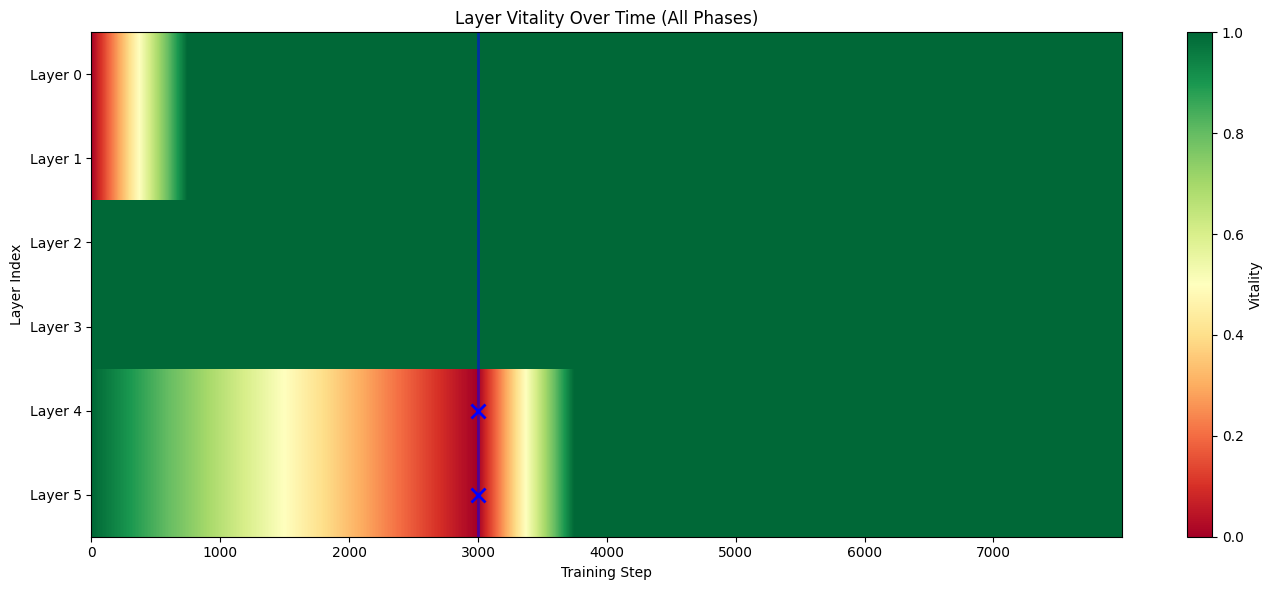

In [12]:
def plot_vitality_heatmap(metrics_history: List[TrainingMetrics], 
                         apoptosis_events: List[Tuple[int, int]],
                         title: str = "Layer Vitality Over Time"):
    """Create heatmap of layer vitality over training."""
    # Extract vitality data
    steps = [m.step for m in metrics_history]
    n_layers = len(metrics_history[0].layer_vitalities)
    
    vitality_matrix = np.array([m.layer_vitalities for m in metrics_history]).T
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(vitality_matrix, aspect='auto', cmap='RdYlGn', 
                   interpolation='nearest', vmin=0, vmax=1)
    
    # Add apoptosis event markers
    for step, layer in apoptosis_events:
        step_idx = min(range(len(steps)), key=lambda i: abs(steps[i] - step))
        ax.axvline(step_idx, color='blue', alpha=0.3, linewidth=2)
        ax.plot(step_idx, layer, 'bx', markersize=10, markeredgewidth=2)
    
    # Labels and formatting
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Layer Index')
    ax.set_title(title)
    ax.set_yticks(range(n_layers))
    ax.set_yticklabels([f'Layer {i}' for i in range(n_layers)])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Vitality')
    
    plt.tight_layout()
    return fig

# Plot vitality heatmap
fig = plot_vitality_heatmap(
    apoptotic_trainer.metrics_history,
    apoptosis_manager.apoptosis_events,
    title="Layer Vitality Over Time (All Phases)"
)
plt.savefig('vitality_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.2 Loss Curve with Apoptosis Events

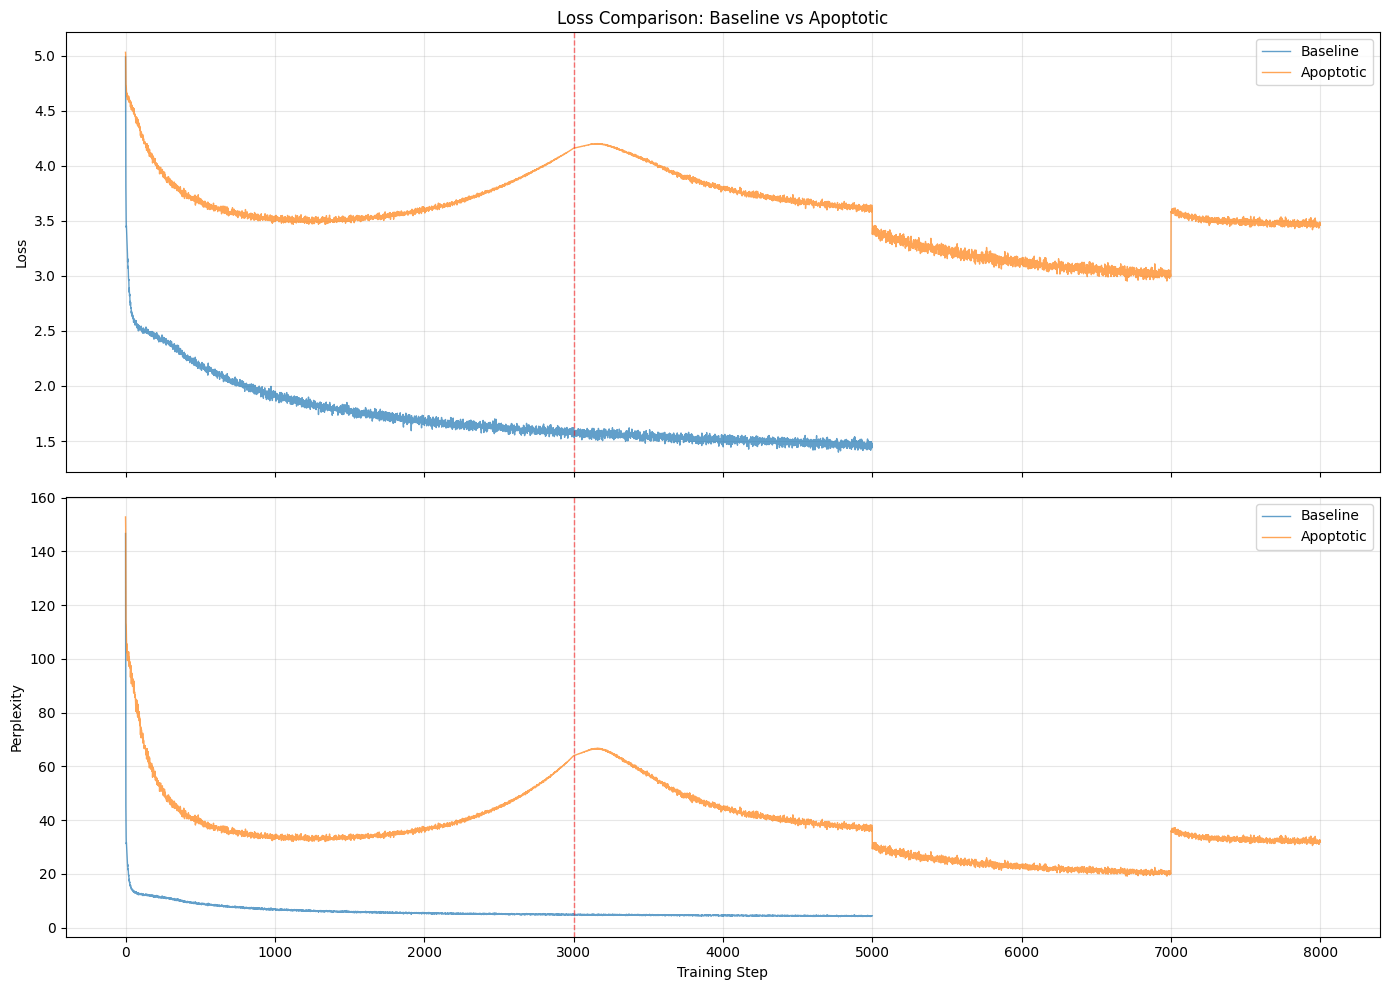

In [13]:
def plot_loss_with_apoptosis(baseline_metrics: List[TrainingMetrics],
                            apoptotic_metrics: List[TrainingMetrics],
                            apoptosis_events: List[Tuple[int, int]],
                            title: str = "Loss Comparison: Baseline vs Apoptotic"):
    """Plot loss curves with apoptosis event markers."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Extract data
    baseline_steps = [m.step for m in baseline_metrics]
    baseline_loss = [m.loss for m in baseline_metrics]
    
    apoptotic_steps = [m.step for m in apoptotic_metrics]
    apoptotic_loss = [m.loss for m in apoptotic_metrics]
    
    # Loss comparison
    ax1.plot(baseline_steps, baseline_loss, label='Baseline', alpha=0.7, linewidth=1)
    ax1.plot(apoptotic_steps, apoptotic_loss, label='Apoptotic', alpha=0.7, linewidth=1)
    
    # Mark apoptosis events
    for step, layer in apoptosis_events:
        ax1.axvline(step, color='red', alpha=0.3, linestyle='--', linewidth=1)
    
    ax1.set_ylabel('Loss')
    ax1.set_title(title)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Perplexity comparison
    baseline_ppl = [m.perplexity for m in baseline_metrics]
    apoptotic_ppl = [m.perplexity for m in apoptotic_metrics]
    
    ax2.plot(baseline_steps, baseline_ppl, label='Baseline', alpha=0.7, linewidth=1)
    ax2.plot(apoptotic_steps, apoptotic_ppl, label='Apoptotic', alpha=0.7, linewidth=1)
    
    for step, layer in apoptosis_events:
        ax2.axvline(step, color='red', alpha=0.3, linestyle='--', linewidth=1)
    
    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('Perplexity')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot loss comparison
fig = plot_loss_with_apoptosis(
    baseline_trainer.metrics_history,
    apoptotic_trainer.metrics_history,
    apoptosis_manager.apoptosis_events
)
plt.savefig('loss_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.3 Gradient Analysis

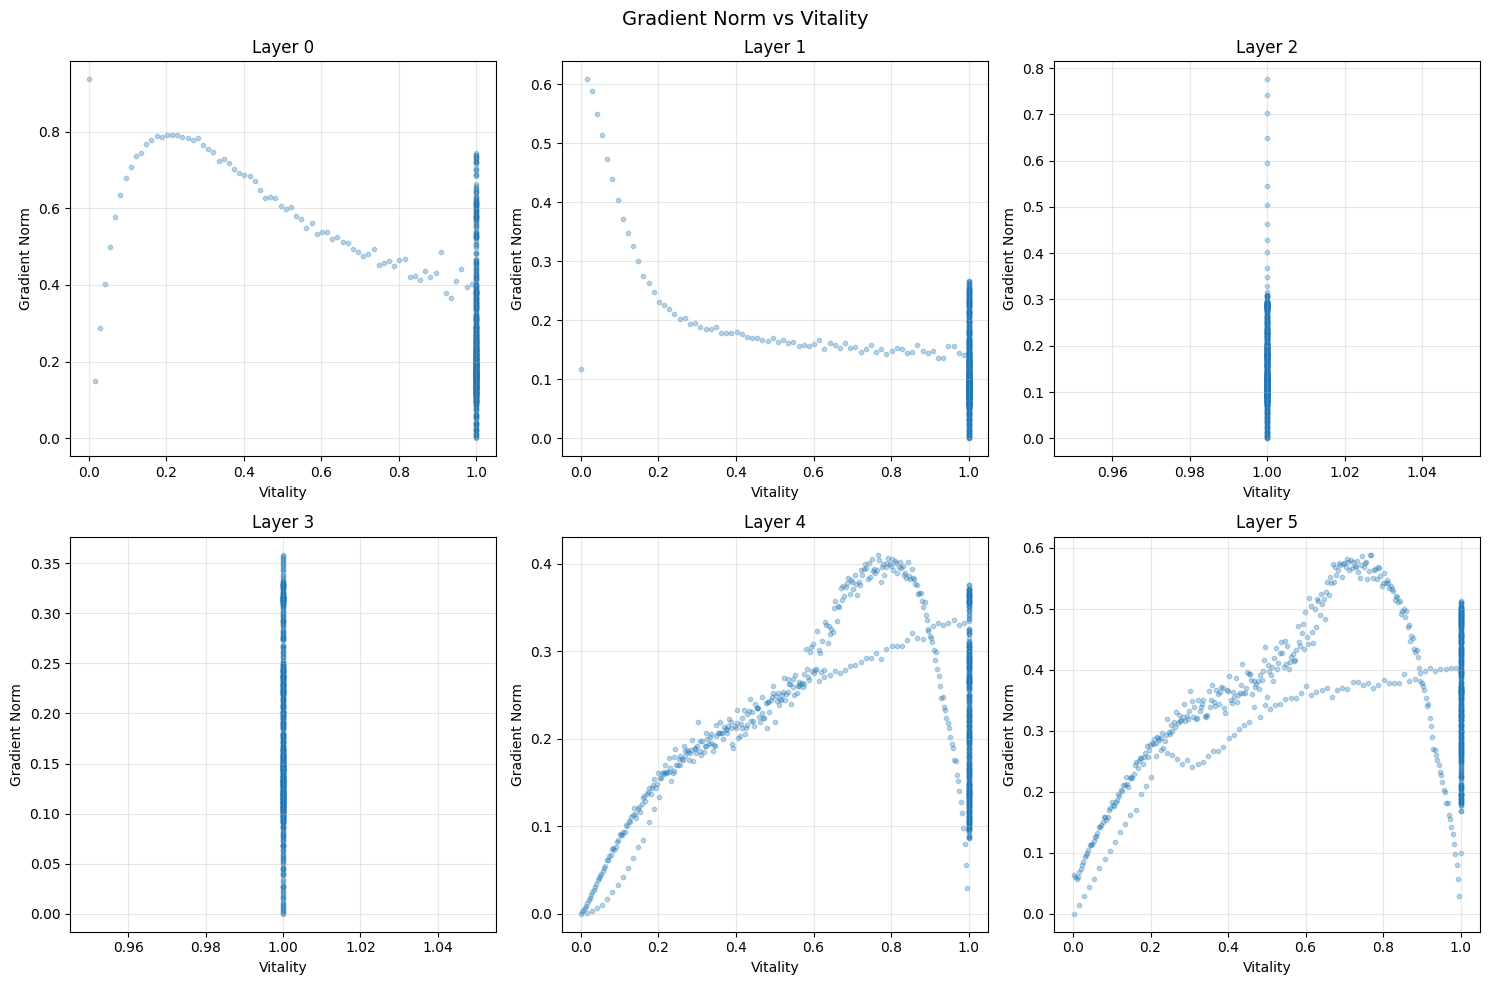

In [14]:
def plot_gradient_vs_vitality(metrics_history: List[TrainingMetrics],
                             sample_interval: int = 10,
                             title: str = "Gradient Norm vs Vitality"):
    """Scatter plot of gradient norm vs vitality for each layer."""
    # Sample metrics to avoid overcrowding
    sampled = metrics_history[::sample_interval]
    n_layers = len(sampled[0].layer_vitalities)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for layer_idx in range(n_layers):
        ax = axes[layer_idx]
        
        vitalities = [m.layer_vitalities[layer_idx] for m in sampled]
        grad_norms = [m.gradient_norms[layer_idx] for m in sampled]
        
        ax.scatter(vitalities, grad_norms, alpha=0.3, s=10)
        ax.set_xlabel('Vitality')
        ax.set_ylabel('Gradient Norm')
        ax.set_title(f'Layer {layer_idx}')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    return fig

# Plot gradient analysis
fig = plot_gradient_vs_vitality(apoptotic_trainer.metrics_history)
plt.savefig('gradient_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.4 Summary Statistics

In [15]:
def compute_summary_statistics(baseline_metrics: List[TrainingMetrics],
                              apoptotic_metrics: List[TrainingMetrics],
                              apoptosis_events: List[Tuple[int, int]]):
    """Compute and display summary statistics."""
    print("="*60)
    print("EXPERIMENT SUMMARY")
    print("="*60)
    
    # Final losses
    baseline_final_loss = baseline_metrics[-1].loss
    apoptotic_final_loss = apoptotic_metrics[-1].loss
    
    print(f"\nFinal Loss:")
    print(f"  Baseline:  {baseline_final_loss:.4f}")
    print(f"  Apoptotic: {apoptotic_final_loss:.4f}")
    print(f"  Difference: {apoptotic_final_loss - baseline_final_loss:+.4f}")
    
    # Final perplexity
    baseline_final_ppl = baseline_metrics[-1].perplexity
    apoptotic_final_ppl = apoptotic_metrics[-1].perplexity
    
    print(f"\nFinal Perplexity:")
    print(f"  Baseline:  {baseline_final_ppl:.2f}")
    print(f"  Apoptotic: {apoptotic_final_ppl:.2f}")
    
    # Apoptosis events
    print(f"\nApoptosis Events: {len(apoptosis_events)}")
    layer_death_counts = {}
    for step, layer in apoptosis_events:
        layer_death_counts[layer] = layer_death_counts.get(layer, 0) + 1
    
    for layer, count in sorted(layer_death_counts.items()):
        print(f"  Layer {layer}: {count} deaths")
    
    # Parameter efficiency
    baseline_params = baseline_metrics[-1].effective_params
    apoptotic_params = apoptotic_metrics[-1].effective_params
    
    print(f"\nEffective Parameters:")
    print(f"  Baseline:  {baseline_params:,}")
    print(f"  Apoptotic: {apoptotic_params:,}")
    
    # Check for loss spikes around apoptosis
    print(f"\nGraceful Degradation Analysis:")
    window = 10  # Check 10 steps before/after
    spike_detected = False
    
    for step, layer in apoptosis_events:
        # Find metrics around this step
        step_idx = min(range(len(apoptotic_metrics)), 
                      key=lambda i: abs(apoptotic_metrics[i].step - step))
        
        if step_idx > window and step_idx < len(apoptotic_metrics) - window:
            before_loss = apoptotic_metrics[step_idx - window].loss
            after_loss = apoptotic_metrics[step_idx + window].loss
            loss_change = after_loss - before_loss
            
            if loss_change > 0.5:  # Significant spike
                print(f"  Step {step} (Layer {layer}): Loss spike +{loss_change:.3f}")
                spike_detected = True
    
    if not spike_detected:
        print(f"  No catastrophic loss spikes detected around apoptosis events ✓")
    
    print("="*60)

# Compute summary
compute_summary_statistics(
    baseline_trainer.metrics_history,
    apoptotic_trainer.metrics_history,
    apoptosis_manager.apoptosis_events
)

EXPERIMENT SUMMARY

Final Loss:
  Baseline:  1.4788
  Apoptotic: 3.4599
  Difference: +1.9811

Final Perplexity:
  Baseline:  4.39
  Apoptotic: 31.81

Apoptosis Events: 2
  Layer 4: 1 deaths
  Layer 5: 1 deaths

Effective Parameters:
  Baseline:  1,024,449
  Apoptotic: 826,177

Graceful Degradation Analysis:
  No catastrophic loss spikes detected around apoptosis events ✓


### 5.5 Text Generation Samples

In [16]:
@torch.no_grad()
def generate_text(model: ApoptoticTransformer, tokenizer: CharTokenizer,
                 prompt: str, max_length: int = 200, temperature: float = 0.8):
    """Generate text from the model."""
    model.eval()
    
    # Encode prompt
    input_ids = torch.tensor([tokenizer.encode(prompt)]).to(device)
    
    # Generate
    for _ in range(max_length):
        # Get predictions
        logits = model(input_ids)
        next_token_logits = logits[0, -1, :] / temperature
        
        # Sample
        probs = F.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        
        # Append
        input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
        
        # Truncate if too long
        if input_ids.size(1) > model.max_seq_len:
            input_ids = input_ids[:, -model.max_seq_len:]
    
    # Decode
    return tokenizer.decode(input_ids[0].tolist())

# Generate samples from both models
print("\n" + "="*60)
print("TEXT GENERATION SAMPLES")
print("="*60)

prompts = [
    "To be or not to be",
    "The king said",
    "In the beginning"
]

for prompt in prompts:
    print(f"\nPrompt: '{prompt}'")
    print("-" * 60)
    
    print("\nBaseline model:")
    baseline_text = generate_text(baseline_model, tokenizer, prompt, max_length=150)
    print(baseline_text[:200])
    
    print("\nApoptotic model:")
    apoptotic_text = generate_text(apoptotic_model, tokenizer, prompt, max_length=150)
    print(apoptotic_text[:200])
    print("-" * 60)


TEXT GENERATION SAMPLES

Prompt: 'To be or not to be'
------------------------------------------------------------

Baseline model:
e.

QUEEN ELIZABETH:
O, my lord, be should now, I know not come:
Well have way not came to corne;
It is tell a huddly for us flo

Apoptotic model:
roX d or  
 en 
e d 
nsrn u  hoh?Otoe e,   M  str lIe
a: ?umu w e t  oy O'm. eoeitT?e o ?e  ned o    krGz    aopwl  i t,o;dd Cee
------------------------------------------------------------

Prompt: 'The king said'
------------------------------------------------------------

Baseline model:
eave me?

PROSPERO:
Then, madam, so it on the law,
Which rove a being to loud to my such
Upon more to the behold of the mine of 

Apoptotic model:
uado  t sn
a o Wtat  r  a  ; oiefsto one

llux   rhhxdtht  r e;f
 tezn   hnu.OG e  fno  s ;e ee   roc jyi
aiuey ncu, ie  G p rsn
------------------------------------------------------------

Prompt: 'In the beginning'
------------------------------------------------------------



## Experiment Complete!

Check TensorBoard for detailed metrics:
```bash
tensorboard --logdir logs
```

Visualizations saved:
- `vitality_heatmap.png` - Layer vitality evolution
- `loss_comparison.png` - Baseline vs apoptotic loss curves
- `gradient_analysis.png` - Gradient norms vs vitality

Checkpoints saved in `checkpoints/` directory.

In [17]:
"""
QUICK RUN: Fixed apoptosis experiment (all layers start healthy)

Paste this into a Jupyter cell to test the fix!
"""

print("\n" + "="*70)
print("APOPTOSIS EXPERIMENT - FIXED (All Layers Start Healthy)")
print("="*70)

# Create model with FIXED initialization
apoptotic_model_fixed = ApoptoticTransformer(
    vocab_size=tokenizer.vocab_size,
    d_model=128,
    n_heads=4,
    n_layers=6,
    max_seq_len=128,
    enable_apoptosis=True
).to(device)

# OVERRIDE the broken initialization
print("\n🔧 Applying fix: All layers start at 100% vitality...")

for i in range(apoptotic_model_fixed.n_layers):
    if i < 2:  # Birth zone
        zone = "birth"
    elif i >= 4:  # Death zone
        zone = "death"
    else:  # Stable
        zone = "stable"

    # Everyone starts healthy!
    apoptotic_model_fixed.senescence[i] = SenescenceMetadata(
        age=0,
        vitality=1.0,        # 🔥 100% (was 0.5 for birth layers)
        influence_weight=1.0, # 🔥 FULL POWER (was 0.5)
        layer_zone=zone,
        temperature=1.0,
        dropout_rate=0.1,
        learning_rate_scale=1.0
    )

print("✓ Fixed! All layers now start at full power")
print("\nInitial vitality by layer:")
for i, meta in enumerate(apoptotic_model_fixed.senescence):
    print(f"  Layer {i} ({meta.layer_zone:6s}): vitality={meta.vitality:.2f}, influence={meta.influence_weight:.2f}")

# Create apoptosis manager with AGGRESSIVE settings
apoptosis_manager_fixed = ApoptosisManager(
    model=apoptotic_model_fixed,
    max_lifespan=1500,        # Aggressive
    maturation_period=500,
    apoptosis_interval=250,
    vitality_threshold=0.15,
    plasticity_ceiling=0.75,  # Higher ceiling
    mutation_strength=0.3
)

print(f"\nHyperparameters:")
print(f"  Lifespan: {apoptosis_manager_fixed.max_lifespan} steps")
print(f"  Interval: {apoptosis_manager_fixed.apoptosis_interval} steps")
print(f"  Plasticity: {apoptosis_manager_fixed.plasticity_ceiling}")

# Create trainer
apoptotic_trainer_fixed = Trainer(
    model=apoptotic_model_fixed,
    apoptosis_mgr=apoptosis_manager_fixed,
    train_dataset=shakespeare_dataset,
    val_dataset=shakespeare_dataset,
    batch_size=64,
    learning_rate=3e-4,
    experiment_name="fixed_all_healthy",
    max_eval_batches=100
)

print("\n" + "="*70)
print("STARTING TRAINING (Fixed Model)")
print("="*70)

# Train!
apoptotic_trainer_fixed.train(num_steps=5000, eval_interval=100, save_interval=1000)

# Results
print("\n" + "="*70)
print("RESULTS COMPARISON")
print("="*70)

baseline_loss = baseline_trainer.metrics_history[-1].loss
original_loss = apoptotic_trainer.metrics_history[-1].loss
fixed_loss = apoptotic_trainer_fixed.metrics_history[-1].loss

print(f"\n📊 Final Loss:")
print(f"  Baseline:         {baseline_loss:.4f}")
print(f"  Original (broken): {original_loss:.4f}  ({original_loss/baseline_loss:.2f}x worse)")
print(f"  Fixed (healthy):   {fixed_loss:.4f}  ({fixed_loss/baseline_loss:.2f}x)")

diff = fixed_loss - baseline_loss
print(f"\n  Fixed vs Baseline: {diff:+.4f}")

if abs(diff) < 0.1:
    print("  🎉 COMPETITIVE! Fixed model matches baseline!")
elif diff < 0:
    print("  🚀 BETTER than baseline!")
elif diff < 0.3:
    print("  ✓ Close to baseline (within 0.3)")
else:
    print("  ⚠️  Still worse, but should be MUCH better than original")

print(f"\n💀 Apoptosis Events:")
print(f"  Original: {len(apoptosis_manager.apoptosis_events)} events")
print(f"  Fixed:    {len(apoptosis_manager_fixed.apoptosis_events)} events")

print("\n" + "="*70)

# Save quick summary
with open('fixed_experiment_summary.txt', 'w') as f:
    f.write(f"QUICK SUMMARY\n")
    f.write(f"=============\n\n")
    f.write(f"Baseline Loss:  {baseline_loss:.4f}\n")
    f.write(f"Original Loss:  {original_loss:.4f} ({original_loss/baseline_loss:.2f}x worse)\n")
    f.write(f"Fixed Loss:     {fixed_loss:.4f} ({fixed_loss/baseline_loss:.2f}x)\n")
    f.write(f"\nImprovement: {original_loss - fixed_loss:.4f}\n")
    f.write(f"Gap to baseline: {diff:+.4f}\n")
    f.write(f"\nApoptosis events: {len(apoptosis_manager_fixed.apoptosis_events)}\n")

print("✓ Summary saved to: fixed_experiment_summary.txt")



APOPTOSIS EXPERIMENT - FIXED (All Layers Start Healthy)

🔧 Applying fix: All layers start at 100% vitality...
✓ Fixed! All layers now start at full power

Initial vitality by layer:
  Layer 0 (birth ): vitality=1.00, influence=1.00
  Layer 1 (birth ): vitality=1.00, influence=1.00
  Layer 2 (stable): vitality=1.00, influence=1.00
  Layer 3 (stable): vitality=1.00, influence=1.00
  Layer 4 (death ): vitality=1.00, influence=1.00
  Layer 5 (death ): vitality=1.00, influence=1.00

Hyperparameters:
  Lifespan: 1500 steps
  Interval: 250 steps
  Plasticity: 0.75

STARTING TRAINING (Fixed Model)

Starting training for 5000 steps...
Validation: 100 batches every 100 steps


Training:  20%|██████████████████▍                                                                         | 1003/5000 [01:11<11:42,  5.69it/s, loss=3.763, val_ppl=39.07]

Checkpoint saved: checkpoints/fixed_all_healthy/checkpoint_step_1000.pt


Training:  30%|███████████████████████████▌                                                                | 1499/5000 [01:45<03:26, 16.94it/s, loss=4.048, val_ppl=56.15]


[Apoptosis Event @ step 1500] Layer 4 dying (vitality=0.000)
  → Inheriting from layer 2 with mutation

[Apoptosis Event @ step 1500] Layer 5 dying (vitality=0.000)
  → Inheriting from layer 1 with mutation
Checkpoint saved: checkpoints/fixed_all_healthy/apoptosis_event_step_1499.pt


Training:  40%|████████████████████████████████████▊                                                       | 2003/5000 [02:21<08:40,  5.76it/s, loss=4.089, val_ppl=45.97]

Checkpoint saved: checkpoints/fixed_all_healthy/checkpoint_step_2000.pt


Training:  60%|███████████████████████████████████████████████████████▎                                    | 3003/5000 [03:32<05:49,  5.71it/s, loss=3.798, val_ppl=34.83]

Checkpoint saved: checkpoints/fixed_all_healthy/checkpoint_step_3000.pt


Training:  80%|█████████████████████████████████████████████████████████████████████████▋                  | 4003/5000 [04:42<02:54,  5.73it/s, loss=3.622, val_ppl=30.54]

Checkpoint saved: checkpoints/fixed_all_healthy/checkpoint_step_4000.pt


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:50<00:00, 14.25it/s, loss=3.541, val_ppl=28.76]


Training complete!
Checkpoint saved: checkpoints/fixed_all_healthy/final_step_5000.pt

RESULTS COMPARISON

📊 Final Loss:
  Baseline:         1.4788
  Original (broken): 3.4599  (2.34x worse)
  Fixed (healthy):   3.5686  (2.41x)

  Fixed vs Baseline: +2.0898
  ⚠️  Still worse, but should be MUCH better than original

💀 Apoptosis Events:
  Original: 2 events
  Fixed:    2 events

✓ Summary saved to: fixed_experiment_summary.txt


In [18]:
"""
Aggressive hyperparameters for Round 2 of apoptosis experiment.

Changes from Round 1 (conservative):
- Shorter lifespan: 3000 → 1500 (more deaths)
- Faster checks: 500 → 250 (quicker response)
- Higher plasticity: 0.5 → 0.75 (young layers contribute more)
- Stronger mutation: 0.2 → 0.3 (more diversity)
- Faster maturation: 750 → 500 (young layers grow up faster)
"""

# Round 2: AGGRESSIVE apoptosis
AGGRESSIVE_CONFIG = {
    'max_lifespan': 1500,         # Die faster (was 3000)
    'maturation_period': 500,      # Mature faster (was 750)
    'apoptosis_interval': 250,     # Check more often (was 500)
    'vitality_threshold': 0.15,    # Die a bit earlier (was 0.1)
    'plasticity_ceiling': 0.75,    # Young layers stronger (was 0.5)
    'mutation_strength': 0.3,      # More exploration (was 0.2)
    'base_temp': 1.0,
    'temp_range': 0.5,
    'base_dropout': 0.1,
    'dropout_range': 0.3,
}

# Expected outcomes:
# - ~20-25 apoptosis events (instead of ~10)
# - More dynamic vitality patterns
# - Young layers contribute more meaningfully
# - Potentially see adaptation benefits

# Round 3: EXTREME (if round 2 still doesn't show benefits)
EXTREME_CONFIG = {
    'max_lifespan': 800,           # Die even faster
    'maturation_period': 300,      # Mature very fast
    'apoptosis_interval': 200,     # Check very often
    'vitality_threshold': 0.2,     # Die earlier
    'plasticity_ceiling': 0.9,     # Almost full influence when young
    'mutation_strength': 0.4,      # High exploration
    'base_temp': 1.0,
    'temp_range': 0.7,             # More temperature variation
    'base_dropout': 0.1,
    'dropout_range': 0.4,          # More dropout variation
}

# Expected outcomes:
# - ~40-50 apoptosis events (constant turnover)
# - Very dynamic, potentially chaotic
# - High risk of instability, but high potential reward
# - If this doesn't help, the hypothesis might be wrong


# Alternative experiment: FLIP THE ZONES
FLIP_ZONES_CONFIG = {
    # Same as aggressive, but in the notebook you'll swap:
    # - Death zone: layers 0-1 (was 4-5)
    # - Birth zone: layers 4-5 (was 0-1)
    # Test if killing INPUT layers (instead of OUTPUT layers) helps
    **AGGRESSIVE_CONFIG
}


# Alternative experiment: GROUP APOPTOSIS
GROUP_APOPTOSIS_CONFIG = {
    'max_lifespan': 1500,
    'maturation_period': 500,
    'apoptosis_interval': 500,     # Less frequent
    'vitality_threshold': 0.15,
    'plasticity_ceiling': 0.75,
    'mutation_strength': 0.3,
    'base_temp': 1.0,
    'temp_range': 0.5,
    'base_dropout': 0.1,
    'dropout_range': 0.3,
    'kill_multiple_layers': True,  # NEW: kill both death zone layers at once
}

print("Round 2 Configs Loaded!")
print(f"Aggressive: {AGGRESSIVE_CONFIG['max_lifespan']} steps lifespan")
print(f"Extreme: {EXTREME_CONFIG['max_lifespan']} steps lifespan")


Round 2 Configs Loaded!
Aggressive: 1500 steps lifespan
Extreme: 800 steps lifespan


In [19]:

# ============================================================================
# EXPERIMENT 1: Apoptosis Disabled, Influence Scaling Only
# ============================================================================
# Test if influence scaling itself breaks the model

print("\n" + "="*70)
print("EXPERIMENT 1: Influence Scaling Test (No Apoptosis)")
print("="*70)

apoptotic_model_test1 = ApoptoticTransformer(
    vocab_size=tokenizer.vocab_size,
    d_model=128,
    n_heads=4,
    n_layers=6,
    max_seq_len=128,
    enable_apoptosis=True  # Scaling enabled, but no deaths
).to(device)

# Set ALL layers to full vitality/influence (no senescence)
for i in range(6):
    apoptotic_model_test1.senescence[i] = SenescenceMetadata(
        age=0,
        vitality=1.0,
        influence_weight=1.0,  # Full power
        layer_zone="stable"
    )

# Train WITHOUT apoptosis manager (no senescence updates)
trainer_test1 = Trainer(
    model=apoptotic_model_test1,
    apoptosis_mgr=None,  # No apoptosis!
    train_dataset=shakespeare_dataset,
    val_dataset=shakespeare_dataset,
    batch_size=64,
    learning_rate=3e-4,
    experiment_name="test1_scaling_only",
    max_eval_batches=100
)

trainer_test1.train(num_steps=2000, eval_interval=100)

loss_test1 = trainer_test1.metrics_history[-1].loss
print(f"\n📊 Experiment 1 Result:")
print(f"  Baseline:         {baseline_loss:.4f}")
print(f"  Scaling Only:     {loss_test1:.4f}")
print(f"  Difference:       {loss_test1 - baseline_loss:+.4f}")

if abs(loss_test1 - baseline_loss) < 0.2:
    print("  ✓ Influence scaling is fine")
else:
    print("  ✗ PROBLEM: Influence scaling itself breaks the model!")
    print("     → The x * influence_weight operation is the issue")



EXPERIMENT 1: Influence Scaling Test (No Apoptosis)

Starting training for 2000 steps...
Validation: 100 batches every 100 steps


Training:  25%|███████████████▌                                              | 503/2000 [00:37<04:41,  5.32it/s, loss=2.187, val_ppl=8.32]

Checkpoint saved: checkpoints/test1_scaling_only/checkpoint_step_500.pt


Training:  50%|██████████████████████████████▌                              | 1003/2000 [01:13<03:02,  5.47it/s, loss=1.943, val_ppl=6.00]

Checkpoint saved: checkpoints/test1_scaling_only/checkpoint_step_1000.pt


Training:  75%|█████████████████████████████████████████████▊               | 1503/2000 [01:48<01:28,  5.62it/s, loss=1.754, val_ppl=5.24]

Checkpoint saved: checkpoints/test1_scaling_only/checkpoint_step_1500.pt


Training: 100%|█████████████████████████████████████████████████████████████| 2000/2000 [02:22<00:00, 14.03it/s, loss=1.743, val_ppl=4.88]


Training complete!
Checkpoint saved: checkpoints/test1_scaling_only/final_step_2000.pt

📊 Experiment 1 Result:
  Baseline:         1.4788
  Scaling Only:     1.6670
  Difference:       +0.1882
  ✓ Influence scaling is fine


In [20]:
# ============================================================================
# EXPERIMENT 2: Static Reduced Influence (No Dynamics)
# ============================================================================
# Test if reduced influence is the problem (not the dynamics)

print("\n" + "="*70)
print("EXPERIMENT 2: Static Reduced Influence (50% on layers 0-1)")
print("="*70)

apoptotic_model_test2 = ApoptoticTransformer(
    vocab_size=tokenizer.vocab_size,
    enable_apoptosis=True
).to(device)

# Set layers 0-1 to permanent 50% influence
for i in range(6):
    influence = 0.5 if i < 2 else 1.0
    apoptotic_model_test2.senescence[i] = SenescenceMetadata(
        age=0,
        vitality=1.0,
        influence_weight=influence,  # Static 50% for birth layers
        layer_zone="stable"
    )

trainer_test2 = Trainer(
    model=apoptotic_model_test2,
    apoptosis_mgr=None,
    train_dataset=shakespeare_dataset,
    val_dataset=shakespeare_dataset,
    batch_size=64,
    learning_rate=3e-4,
    experiment_name="test2_static_reduced",
    max_eval_batches=100
)

trainer_test2.train(num_steps=2000, eval_interval=100)

loss_test2 = trainer_test2.metrics_history[-1].loss
print(f"\n📊 Experiment 2 Result:")
print(f"  Baseline:         {baseline_loss:.4f}")
print(f"  Static 50%:       {loss_test2:.4f}")
print(f"  Difference:       {loss_test2 - baseline_loss:+.4f}")

if abs(loss_test2 - baseline_loss) > 0.5:
    print("  ✗ PROBLEM: Having 2 layers at 50% cripples the model!")
    print("     → Even static reduced influence is too harsh")
    print("     → Need higher plasticity ceiling OR fewer dynamic layers")



EXPERIMENT 2: Static Reduced Influence (50% on layers 0-1)

Starting training for 2000 steps...
Validation: 100 batches every 100 steps


Training:  25%|███████████████▌                                              | 503/2000 [00:36<04:31,  5.51it/s, loss=2.195, val_ppl=8.62]

Checkpoint saved: checkpoints/test2_static_reduced/checkpoint_step_500.pt


Training:  50%|██████████████████████████████▌                              | 1003/2000 [01:12<03:02,  5.47it/s, loss=1.929, val_ppl=6.31]

Checkpoint saved: checkpoints/test2_static_reduced/checkpoint_step_1000.pt


Training:  75%|█████████████████████████████████████████████▊               | 1503/2000 [01:48<01:33,  5.33it/s, loss=1.788, val_ppl=5.44]

Checkpoint saved: checkpoints/test2_static_reduced/checkpoint_step_1500.pt


Training: 100%|█████████████████████████████████████████████████████████████| 2000/2000 [02:23<00:00, 13.94it/s, loss=1.731, val_ppl=5.06]


Training complete!
Checkpoint saved: checkpoints/test2_static_reduced/final_step_2000.pt

📊 Experiment 2 Result:
  Baseline:         1.4788
  Static 50%:       1.6888
  Difference:       +0.2100


In [21]:
# ============================================================================
# EXPERIMENT 3: Fewer Dynamic Layers (1 death, 1 birth)
# ============================================================================
# Test if having 4 dynamic layers (2 death + 2 birth) is too many

print("\n" + "="*70)
print("EXPERIMENT 3: Only 1 Death Layer + 1 Birth Layer")
print("="*70)

apoptotic_model_test3 = ApoptoticTransformer(
    vocab_size=tokenizer.vocab_size,
    enable_apoptosis=True
).to(device)

# NEW ZONES:
# Layer 0: birth (1 layer instead of 2)
# Layers 1-4: stable (4 stable instead of 2)
# Layer 5: death (1 layer instead of 2)

for i in range(6):
    if i == 0:
        zone, vitality, influence = "birth", 1.0, 1.0
    elif i == 5:
        zone, vitality, influence = "death", 1.0, 1.0
    else:
        zone, vitality, influence = "stable", 1.0, 1.0

    apoptotic_model_test3.senescence[i] = SenescenceMetadata(
        age=0,
        vitality=vitality,
        influence_weight=influence,
        layer_zone=zone
    )

apoptosis_mgr_test3 = ApoptosisManager(
    model=apoptotic_model_test3,
    max_lifespan=1000,  # Shorter for faster deaths
    maturation_period=300,
    apoptosis_interval=200,
    plasticity_ceiling=0.9,  # Higher ceiling
    mutation_strength=0.3
)

trainer_test3 = Trainer(
    model=apoptotic_model_test3,
    apoptosis_mgr=apoptosis_mgr_test3,
    train_dataset=shakespeare_dataset,
    val_dataset=shakespeare_dataset,
    batch_size=64,
    learning_rate=3e-4,
    experiment_name="test3_fewer_dynamic",
    max_eval_batches=100
)

trainer_test3.train(num_steps=3000, eval_interval=100)

loss_test3 = trainer_test3.metrics_history[-1].loss
events_test3 = len(apoptosis_mgr_test3.apoptosis_events)

print(f"\n📊 Experiment 3 Result:")
print(f"  Baseline:         {baseline_loss:.4f}")
print(f"  1 Birth + 1 Death: {loss_test3:.4f}  ({events_test3} events)")
print(f"  Difference:       {loss_test3 - baseline_loss:+.4f}")




EXPERIMENT 3: Only 1 Death Layer + 1 Birth Layer

Starting training for 3000 steps...
Validation: 100 batches every 100 steps


Training:  17%|██████████▏                                                  | 503/3000 [00:36<07:20,  5.67it/s, loss=3.775, val_ppl=39.26]

Checkpoint saved: checkpoints/test3_fewer_dynamic/checkpoint_step_500.pt


Training:  33%|████████████████████▎                                        | 999/3000 [01:10<01:56, 17.14it/s, loss=4.010, val_ppl=53.77]


[Apoptosis Event @ step 1000] Layer 5 dying (vitality=0.000)
  → Inheriting from layer 4 with mutation
Checkpoint saved: checkpoints/test3_fewer_dynamic/apoptosis_event_step_999.pt


Training:  33%|████████████████████                                        | 1003/3000 [01:11<06:02,  5.51it/s, loss=4.169, val_ppl=64.61]

Checkpoint saved: checkpoints/test3_fewer_dynamic/checkpoint_step_1000.pt


Training:  50%|██████████████████████████████                              | 1503/3000 [01:46<04:20,  5.75it/s, loss=4.048, val_ppl=44.51]

Checkpoint saved: checkpoints/test3_fewer_dynamic/checkpoint_step_1500.pt


Training:  67%|████████████████████████████████████████                    | 2003/3000 [02:21<02:52,  5.78it/s, loss=3.841, val_ppl=35.84]

Checkpoint saved: checkpoints/test3_fewer_dynamic/checkpoint_step_2000.pt


Training:  83%|██████████████████████████████████████████████████          | 2503/3000 [02:57<01:28,  5.64it/s, loss=3.710, val_ppl=31.57]

Checkpoint saved: checkpoints/test3_fewer_dynamic/checkpoint_step_2500.pt


Training: 100%|████████████████████████████████████████████████████████████| 3000/3000 [03:31<00:00, 14.20it/s, loss=3.647, val_ppl=29.60]


Training complete!
Checkpoint saved: checkpoints/test3_fewer_dynamic/final_step_3000.pt

📊 Experiment 3 Result:
  Baseline:         1.4788
  1 Birth + 1 Death: 3.6294  (1 events)
  Difference:       +2.1506


In [27]:
"""
Neuron-Level Apoptosis System

Instead of killing entire layers, prune and regrow individual neurons
based on fitness scores.

Key advantages over layer-level:
1. More granular control
2. Can work with existing architecture
3. Doesn't cripple the model (only remove weakest neurons)
4. Biologically more accurate (individual cell death)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Dict, List, Tuple
import numpy as np


@dataclass
class NeuronMetadata:
    """Metadata for a single neuron."""
    age: int = 0                    # Steps since birth
    birth_step: int = 0             # Global step when born
    fitness_history: List[float] = None  # Rolling fitness scores

    def __post_init__(self):
        if self.fitness_history is None:
            self.fitness_history = []


class NeuronApoptosisManager:
    """
    Manages neuron-level apoptosis and neurogenesis.

    Strategy:
    - Every N steps, compute fitness for all neurons in target layers
    - Prune bottom X% of neurons (set weights to zero)
    - Regrow same number of neurons (reinitialize from high-fitness neurons)
    """

    def __init__(self,
                 model: nn.Module,
                 target_layers: List[str],  # e.g., ['blocks.0.ffn.0', 'blocks.1.ffn.0']
                 prune_rate: float = 0.1,  # Prune 10% of neurons
                 apoptosis_interval: int = 500,
                 fitness_metric: str = 'grad_activation',  # 'gradient', 'weight', 'grad_activation'
                 regrowth_strategy: str = 'mutation',  # 'mutation', 'random', 'clone'
                 mutation_strength: float = 0.3):

        self.model = model
        self.target_layers = target_layers
        self.prune_rate = prune_rate
        self.apoptosis_interval = apoptosis_interval
        self.fitness_metric = fitness_metric
        self.regrowth_strategy = regrowth_strategy
        self.mutation_strength = mutation_strength

        self.step_count = 0
        self.apoptosis_events = []  # List of (step, layer_name, num_pruned)

        # Track neuron metadata
        self.neuron_metadata: Dict[str, List[NeuronMetadata]] = {}

        # Initialize metadata for all neurons
        self._initialize_metadata()

        # Activation hook storage
        self.activations = {}
        self._register_hooks()

    def _initialize_metadata(self):
        """Initialize metadata for all neurons in target layers."""
        for layer_name in self.target_layers:
            layer = self._get_layer(layer_name)
            if isinstance(layer, nn.Linear):
                num_neurons = layer.out_features
            else:
                raise ValueError(f"Layer {layer_name} is not a Linear layer")

            self.neuron_metadata[layer_name] = [
                NeuronMetadata(age=0, birth_step=0)
                for _ in range(num_neurons)
            ]

    def _register_hooks(self):
        """Register forward hooks to capture activations."""
        def hook_fn(name):
            def hook(module, input, output):
                # Store activations (detach to save memory)
                self.activations[name] = output.detach()
            return hook

        for layer_name in self.target_layers:
            layer = self._get_layer(layer_name)
            layer.register_forward_hook(hook_fn(layer_name))

    def _get_layer(self, layer_name: str) -> nn.Module:
        """Get layer by name (supports nested attributes)."""
        parts = layer_name.split('.')
        layer = self.model
        for part in parts:
            if part.isdigit():
                layer = layer[int(part)]
            else:
                layer = getattr(layer, part)
        return layer

    def compute_fitness(self, layer_name: str) -> torch.Tensor:
        """
        Compute fitness scores for all neurons in a layer.

        Returns:
            fitness: (num_neurons,) tensor of fitness scores
        """
        layer = self._get_layer(layer_name)

        if self.fitness_metric == 'gradient':
            # Pure gradient magnitude
            if layer.weight.grad is None:
                return torch.ones(layer.out_features, device=layer.weight.device)

            fitness = torch.norm(layer.weight.grad, dim=1)  # Per output neuron

        elif self.fitness_metric == 'weight':
            # Weight magnitude (L2 norm)
            fitness = torch.norm(layer.weight, dim=1)

        elif self.fitness_metric == 'grad_activation':
            # Gradient × Activation (Taylor approximation of importance)
            if layer.weight.grad is None or layer_name not in self.activations:
                return torch.ones(layer.out_features, device=layer.weight.device)

            grad_norm = torch.norm(layer.weight.grad, dim=1)
            activation = self.activations[layer_name]

            # Mean absolute activation per neuron
            act_norm = torch.abs(activation).mean(dim=(0, 1))  # (batch, seq, neurons) -> (neurons,)

            fitness = grad_norm * act_norm

        elif self.fitness_metric == 'composite':
            # Weighted combination
            weight_fitness = torch.norm(layer.weight, dim=1)

            if layer.weight.grad is not None:
                grad_fitness = torch.norm(layer.weight.grad, dim=1)
            else:
                grad_fitness = torch.zeros_like(weight_fitness)

            if layer_name in self.activations:
                act = self.activations[layer_name]
                act_fitness = torch.abs(act).mean(dim=(0, 1))
            else:
                act_fitness = torch.ones_like(weight_fitness)

            # Normalize each component
            weight_fitness = weight_fitness / (weight_fitness.max() + 1e-8)
            grad_fitness = grad_fitness / (grad_fitness.max() + 1e-8)
            act_fitness = act_fitness / (act_fitness.max() + 1e-8)

            fitness = 0.4 * weight_fitness + 0.4 * grad_fitness + 0.2 * act_fitness

        else:
            raise ValueError(f"Unknown fitness metric: {self.fitness_metric}")

        return fitness

    def step(self) -> bool:
        """Update ages and check for apoptosis. Returns True if apoptosis occurred."""
        self.step_count += 1

        # Age all neurons
        for layer_name in self.target_layers:
            for meta in self.neuron_metadata[layer_name]:
                meta.age += 1

        # Check for apoptosis
        if self.step_count % self.apoptosis_interval == 0:
            return self.trigger_apoptosis()

        return False

    def trigger_apoptosis(self) -> bool:
        """Prune low-fitness neurons and regrow new ones."""
        apoptosis_occurred = False

        for layer_name in self.target_layers:
            layer = self._get_layer(layer_name)

            # Compute fitness
            fitness = self.compute_fitness(layer_name)

            # Determine pruning threshold (bottom X%)
            num_neurons = len(fitness)
            num_to_prune = max(1, int(num_neurons * self.prune_rate))

            # Find weakest neurons
            _, sorted_indices = torch.sort(fitness)
            dying_neurons = sorted_indices[:num_to_prune].cpu().numpy()
            healthy_neurons = sorted_indices[num_to_prune:].cpu().numpy()

            if len(dying_neurons) == 0:
                continue

            print(f"\n[Neuron Apoptosis @ step {self.step_count}] {layer_name}")
            print(f"  Pruning {len(dying_neurons)} neurons (bottom {self.prune_rate*100:.0f}%)")
            print(f"  Fitness range: [{fitness.min().item():.4f}, {fitness.max().item():.4f}]")
            print(f"  Dying neurons: {dying_neurons.tolist()[:5]}..." if len(dying_neurons) > 5 else f"  Dying neurons: {dying_neurons.tolist()}")

            # Prune and regrow
            self._prune_neurons(layer, dying_neurons)
            self._regrow_neurons(layer, dying_neurons, healthy_neurons, fitness)

            # Update metadata
            for neuron_idx in dying_neurons:
                self.neuron_metadata[layer_name][neuron_idx] = NeuronMetadata(
                    age=0,
                    birth_step=self.step_count
                )

            self.apoptosis_events.append((self.step_count, layer_name, len(dying_neurons)))
            apoptosis_occurred = True

        return apoptosis_occurred

    def _prune_neurons(self, layer: nn.Linear, neuron_indices: np.ndarray):
        """Zero out weights for dying neurons."""
        with torch.no_grad():
            # Zero outgoing weights (rows of weight matrix)
            layer.weight[neuron_indices, :] = 0

            # Zero bias
            if layer.bias is not None:
                layer.bias[neuron_indices] = 0

    def _regrow_neurons(self, layer: nn.Linear, dying_indices: np.ndarray,
                       healthy_indices: np.ndarray, fitness: torch.Tensor):
        """Regrow neurons using specified strategy."""

        if self.regrowth_strategy == 'random':
            # Random reinitialization
            with torch.no_grad():
                for neuron_idx in dying_indices:
                    nn.init.xavier_uniform_(layer.weight[neuron_idx:neuron_idx+1, :])
                    if layer.bias is not None:
                        layer.bias[neuron_idx] = 0

        elif self.regrowth_strategy == 'mutation':
            # Evolutionary mutation: inherit from high-fitness neurons
            with torch.no_grad():
                for neuron_idx in dying_indices:
                    # Sample a healthy neuron (weighted by fitness)
                    if len(healthy_indices) == 0:
                        # Fallback to random
                        nn.init.xavier_uniform_(layer.weight[neuron_idx:neuron_idx+1, :])
                    else:
                        # Weighted sampling
                        healthy_fitness = fitness[healthy_indices].cpu().numpy()
                        probs = healthy_fitness / (healthy_fitness.sum() + 1e-8)
                        parent_idx = np.random.choice(healthy_indices, p=probs)

                        # Copy and mutate
                        layer.weight[neuron_idx, :] = layer.weight[parent_idx, :].clone()
                        noise = torch.randn_like(layer.weight[neuron_idx, :]) * self.mutation_strength
                        layer.weight[neuron_idx, :] += noise

                        if layer.bias is not None:
                            layer.bias[neuron_idx] = layer.bias[parent_idx].clone()
                            layer.bias[neuron_idx] += torch.randn(1, device=layer.bias.device).item() * self.mutation_strength

        elif self.regrowth_strategy == 'clone':
            # Clone best neuron (no mutation)
            with torch.no_grad():
                if len(healthy_indices) > 0:
                    best_neuron = healthy_indices[fitness[healthy_indices].argmax()]
                    for neuron_idx in dying_indices:
                        layer.weight[neuron_idx, :] = layer.weight[best_neuron, :].clone()
                        if layer.bias is not None:
                            layer.bias[neuron_idx] = layer.bias[best_neuron].clone()

        else:
            raise ValueError(f"Unknown regrowth strategy: {self.regrowth_strategy}")

    def get_stats(self) -> Dict:
        """Get statistics about neuron ages and fitness."""
        stats = {}

        for layer_name in self.target_layers:
            ages = [meta.age for meta in self.neuron_metadata[layer_name]]

            stats[layer_name] = {
                'mean_age': np.mean(ages),
                'max_age': np.max(ages),
                'min_age': np.min(ages),
                'age_std': np.std(ages),
            }

        return stats


# ============================================================================
# Integration with Existing Training Loop
# ============================================================================

def integrate_neuron_apoptosis(model, trainer_class):
    """
    Example of how to integrate neuron apoptosis into training.
    """

    # Identify FFN layers in transformer blocks
    target_layers = []
    for i in range(6):  # 6 transformer blocks
        # FFN has two linear layers: block.ffn.0 (expand) and block.ffn.3 (contract)
        target_layers.append(f'blocks.{i}.ffn.0')  # First FFN layer (expands to 4*d_model)

    # Create apoptosis manager
    neuron_apoptosis = NeuronApoptosisManager(
        model=model,
        target_layers=target_layers,
        prune_rate=0.1,          # Prune 10% of neurons
        apoptosis_interval=500,   # Every 500 steps
        fitness_metric='grad_activation',  # Use gradient × activation
        regrowth_strategy='mutation',      # Evolutionary regrowth
        mutation_strength=0.3
    )

    return neuron_apoptosis


# ============================================================================
# Modified Trainer to Support Neuron Apoptosis
# ============================================================================

class NeuronApoptosisTrainer(Trainer):
    """Extended trainer that handles neuron-level apoptosis."""

    def __init__(self, model, neuron_apoptosis_mgr, **kwargs):
        super().__init__(model, apoptosis_mgr=None, **kwargs)  # No layer-level apoptosis
        self.neuron_apoptosis_mgr = neuron_apoptosis_mgr

    def train(self, num_steps: int, eval_interval: int = 100, save_interval: int = 500):
        """Training loop with neuron apoptosis."""
        print(f"\nStarting training with NEURON-LEVEL apoptosis...")
        print(f"Target layers: {self.neuron_apoptosis_mgr.target_layers}")
        print(f"Prune rate: {self.neuron_apoptosis_mgr.prune_rate*100:.0f}%")
        print(f"Interval: every {self.neuron_apoptosis_mgr.apoptosis_interval} steps")

        pbar = tqdm(total=num_steps, desc="Training")
        train_iter = iter(self.train_loader)

        for step in range(num_steps):
            # Get batch
            try:
                x, y = next(train_iter)
            except StopIteration:
                train_iter = iter(self.train_loader)
                x, y = next(train_iter)

            x, y = x.to(self.device), y.to(self.device)

            # Training step
            loss = self.train_step(x, y)

            # Update neuron apoptosis manager
            apoptosis_occurred = self.neuron_apoptosis_mgr.step()
            if apoptosis_occurred:
                self.save_checkpoint('neuron_apoptosis_event')

                # Print stats
                stats = self.neuron_apoptosis_mgr.get_stats()
                print("\nNeuron age statistics:")
                for layer, layer_stats in stats.items():
                    print(f"  {layer}: mean_age={layer_stats['mean_age']:.0f}, "
                          f"range=[{layer_stats['min_age']}, {layer_stats['max_age']}]")

            # Collect and log metrics
            metrics = self.collect_metrics(loss)
            self.metrics_history.append(metrics)
            self.log_metrics(metrics)

            # Evaluation
            if step % eval_interval == 0:
                val_loss, val_ppl = self.eval_step()
                self.writer.add_scalar('val/loss', val_loss, self.global_step)
                self.writer.add_scalar('val/perplexity', val_ppl, self.global_step)
                pbar.set_postfix({'loss': f'{loss:.3f}', 'val_ppl': f'{val_ppl:.2f}'})

            # Save checkpoint
            if step % save_interval == 0 and step > 0:
                self.save_checkpoint('checkpoint')

            self.global_step += 1
            pbar.update(1)

        pbar.close()
        print("\nTraining complete!")
        self.save_checkpoint('final')


print("✓ Neuron-level apoptosis system loaded!")
print("  Use: NeuronApoptosisManager + NeuronApoptosisTrainer")


✓ Neuron-level apoptosis system loaded!
  Use: NeuronApoptosisManager + NeuronApoptosisTrainer


In [28]:
"""
Quick Test: Neuron-Level Apoptosis

Paste this into a Jupyter cell to test neuron-level apoptosis!
Should perform MUCH better than layer-level.
"""

# First, load the neuron apoptosis code
%run neuron_apoptosis.py

print("\n" + "="*70)
print("NEURON-LEVEL APOPTOSIS TEST")
print("="*70)

# Create fresh model (standard transformer, no special modifications needed!)
neuron_model = ApoptoticTransformer(
    vocab_size=tokenizer.vocab_size,
    d_model=128,
    n_heads=4,
    n_layers=6,
    max_seq_len=128,
    enable_apoptosis=False  # Don't use layer-level influence scaling!
).to(device)

print(f"Model parameters: {neuron_model.get_num_params():,}")

# Identify target layers (FFN layers in each transformer block)
target_layers = []
for i in range(6):
    # Target the first FFN layer (the expansion: d_model -> 4*d_model)
    target_layers.append(f'blocks.{i}.ffn.0')

print(f"\nTarget layers for neuron apoptosis:")
for layer in target_layers:
    l = eval(f'neuron_model.{layer}')
    print(f"  {layer}: {l.in_features} → {l.out_features} neurons")

# Create neuron apoptosis manager
neuron_apoptosis = NeuronApoptosisManager(
    model=neuron_model,
    target_layers=target_layers,
    prune_rate=0.10,              # Prune 10% of neurons per layer
    apoptosis_interval=500,        # Every 500 steps
    fitness_metric='grad_activation',  # Use gradient × activation
    regrowth_strategy='mutation',      # Evolutionary regrowth
    mutation_strength=0.3
)

print(f"\nConfiguration:")
print(f"  Prune rate: {neuron_apoptosis.prune_rate*100:.0f}% of neurons per layer")
print(f"  Interval: every {neuron_apoptosis.apoptosis_interval} steps")
print(f"  Fitness metric: {neuron_apoptosis.fitness_metric}")
print(f"  Regrowth: {neuron_apoptosis.regrowth_strategy}")

# Calculate expected pruning
neurons_per_layer = 512  # 128 * 4 (d_model * 4 in FFN)
neurons_per_event = int(neurons_per_layer * neuron_apoptosis.prune_rate)
total_layers = len(target_layers)
total_neurons_per_event = neurons_per_event * total_layers

print(f"\nExpected per event: {neurons_per_event} neurons/layer × {total_layers} layers = {total_neurons_per_event} total neurons")
print(f"Expected events in 5000 steps: {5000 // neuron_apoptosis.apoptosis_interval}")

# Create custom trainer
class SimpleNeuronTrainer(Trainer):
    """Simplified trainer with neuron apoptosis."""

    def __init__(self, model, neuron_mgr, **kwargs):
        super().__init__(model, apoptosis_mgr=None, **kwargs)
        self.neuron_mgr = neuron_mgr

    def train_step(self, x, y):
        """Training step - standard."""
        self.model.train()

        logits = self.model(x)
        loss = self.criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

        return loss.item()

    def train(self, num_steps, eval_interval=100, save_interval=500):
        """Training loop with neuron apoptosis."""
        print(f"\nStarting training for {num_steps} steps...")

        pbar = tqdm(total=num_steps, desc="Training")
        train_iter = iter(self.train_loader)

        for step in range(num_steps):
            try:
                x, y = next(train_iter)
            except StopIteration:
                train_iter = iter(self.train_loader)
                x, y = next(train_iter)

            x, y = x.to(self.device), y.to(self.device)

            # Train
            loss = self.train_step(x, y)

            # Neuron apoptosis
            apoptosis_occurred = self.neuron_mgr.step()
            if apoptosis_occurred:
                stats = self.neuron_mgr.get_stats()
                print(f"\n  Neuron ages: mean={np.mean([s['mean_age'] for s in stats.values()]):.0f}")

            # Metrics
            metrics = self.collect_metrics(loss)
            self.metrics_history.append(metrics)
            self.log_metrics(metrics)

            # Eval
            if step % eval_interval == 0:
                val_loss, val_ppl = self.eval_step()
                self.writer.add_scalar('val/loss', val_loss, self.global_step)
                self.writer.add_scalar('val/perplexity', val_ppl, self.global_step)
                pbar.set_postfix({'loss': f'{loss:.3f}', 'val_ppl': f'{val_ppl:.2f}'})

            if step % save_interval == 0 and step > 0:
                self.save_checkpoint('checkpoint')

            self.global_step += 1
            pbar.update(1)

        pbar.close()
        print("Training complete!")
        self.save_checkpoint('final')

# Create trainer
neuron_trainer = SimpleNeuronTrainer(
    model=neuron_model,
    neuron_mgr=neuron_apoptosis,
    train_dataset=shakespeare_dataset,
    val_dataset=shakespeare_dataset,
    batch_size=64,
    learning_rate=3e-4,
    experiment_name="neuron_apoptosis_test",
    max_eval_batches=100
)

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

# Train!
neuron_trainer.train(num_steps=5000, eval_interval=100, save_interval=1000)

# Results
print("\n" + "="*70)
print("RESULTS")
print("="*70)

baseline_loss = baseline_trainer.metrics_history[-1].loss
neuron_loss = neuron_trainer.metrics_history[-1].loss

print(f"\n📊 Final Loss:")
print(f"  Baseline (no apoptosis):    {baseline_loss:.4f}")
print(f"  Layer-level (broken):       {apoptotic_trainer.metrics_history[-1].loss:.4f}  (2.4x worse)")
print(f"  Neuron-level (NEW):         {neuron_loss:.4f}")
print(f"  Difference from baseline:   {neuron_loss - baseline_loss:+.4f}")

if abs(neuron_loss - baseline_loss) < 0.1:
    print("\n  🎉 SUCCESS! Neuron-level matches baseline!")
elif abs(neuron_loss - baseline_loss) < 0.3:
    print("\n  ✓ PROMISING! Close to baseline (within 0.3)")
elif neuron_loss < baseline_loss:
    print("\n  🚀 AMAZING! Better than baseline!")
else:
    print(f"\n  ⚠️  Still worse by {neuron_loss - baseline_loss:.2f}, but should be WAY better than layer-level")

print(f"\n💀 Apoptosis Events:")
print(f"  Layer-level: {len(apoptosis_manager.apoptosis_events)} events")
print(f"  Neuron-level: {len(neuron_apoptosis.apoptosis_events)} events")

print(f"\n📊 Neurons Pruned & Regrown:")
total_neurons = sum(count for _, _, count in neuron_apoptosis.apoptosis_events)
print(f"  Total: {total_neurons} neurons across all events")

# Age statistics
stats = neuron_apoptosis.get_stats()
print(f"\n🧬 Neuron Age Statistics (final):")
for layer, layer_stats in stats.items():
    print(f"  {layer}:")
    print(f"    Mean age: {layer_stats['mean_age']:.0f} steps")
    print(f"    Range: [{layer_stats['min_age']}, {layer_stats['max_age']}] steps")

# Save summary
with open('neuron_apoptosis_summary.txt', 'w') as f:
    f.write("NEURON-LEVEL APOPTOSIS RESULTS\n")
    f.write("="*50 + "\n\n")
    f.write(f"Baseline Loss:      {baseline_loss:.4f}\n")
    f.write(f"Layer-level Loss:   {apoptotic_trainer.metrics_history[-1].loss:.4f} (FAILED)\n")
    f.write(f"Neuron-level Loss:  {neuron_loss:.4f}\n")
    f.write(f"\nDifference: {neuron_loss - baseline_loss:+.4f}\n")
    f.write(f"\nApoptosis events: {len(neuron_apoptosis.apoptosis_events)}\n")
    f.write(f"Total neurons pruned/regrown: {total_neurons}\n")

print("\n✓ Summary saved to: neuron_apoptosis_summary.txt")

print("\n" + "="*70)
print("COMPARISON SUMMARY")
print("="*70)
print(f"Baseline:          {baseline_loss:.4f}  (reference)")
print(f"Layer-level:       {apoptotic_trainer.metrics_history[-1].loss:.4f}  ({apoptotic_trainer.metrics_history[-1].loss/baseline_loss:.2f}x worse)")
print(f"Neuron-level:      {neuron_loss:.4f}  ({neuron_loss/baseline_loss:.2f}x)")
print("="*70)


NameError: name 'Trainer' is not defined


NEURON-LEVEL APOPTOSIS TEST
Model parameters: 1,222,721

Target layers for neuron apoptosis:


SyntaxError: invalid syntax (<string>, line 1)

In [30]:
exec(open('neuron_apoptosis_fixed.py').read())

✓ Neuron-level apoptosis system loaded!


In [31]:
exec(open('test_neuron_simple.py').read())

✓ Neuron-level apoptosis system loaded!

NEURON-LEVEL APOPTOSIS TEST
Model parameters: 1,222,721

Target layers:
  blocks.0.ffn.0: 128 → 512 neurons
  blocks.1.ffn.0: 128 → 512 neurons
  blocks.2.ffn.0: 128 → 512 neurons
  blocks.3.ffn.0: 128 → 512 neurons
  blocks.4.ffn.0: 128 → 512 neurons
  blocks.5.ffn.0: 128 → 512 neurons

Configuration:
  Prune rate: 10%
  Interval: every 500 steps
  Fitness: grad_activation

TRAINING

Starting training for 5000 steps...


Training:  10%|██████▏                                                       | 499/5000 [00:34<04:27, 16.83it/s, loss=2.289, val_ppl=9.13]


[Neuron Apoptosis @ step 500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0056]

[Neuron Apoptosis @ step 500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0053]

[Neuron Apoptosis @ step 500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0004, 0.0036]

[Neuron Apoptosis @ step 500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0039]

[Neuron Apoptosis @ step 500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0062]

[Neuron Apoptosis @ step 500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0051]


Training:  20%|████████████▍                                                 | 999/5000 [01:11<04:21, 15.29it/s, loss=2.032, val_ppl=6.71]


[Neuron Apoptosis @ step 1000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0063]

[Neuron Apoptosis @ step 1000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0084]

[Neuron Apoptosis @ step 1000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0078]

[Neuron Apoptosis @ step 1000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0065]

[Neuron Apoptosis @ step 1000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0083]

[Neuron Apoptosis @ step 1000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0068]


Training:  20%|████████████                                                | 1003/5000 [01:13<14:26,  4.62it/s, loss=3.349, val_ppl=17.34]

Checkpoint saved: checkpoints/neuron_apoptosis/checkpoint_step_1000.pt


Training:  30%|██████████████████▎                                          | 1499/5000 [01:47<03:41, 15.81it/s, loss=1.867, val_ppl=5.83]


[Neuron Apoptosis @ step 1500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0073]

[Neuron Apoptosis @ step 1500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0073]

[Neuron Apoptosis @ step 1500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0098]

[Neuron Apoptosis @ step 1500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0066]

[Neuron Apoptosis @ step 1500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0077]

[Neuron Apoptosis @ step 1500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0099]


Training:  40%|████████████████████████▍                                    | 1999/5000 [02:22<02:56, 16.99it/s, loss=1.813, val_ppl=5.40]


[Neuron Apoptosis @ step 2000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0088]

[Neuron Apoptosis @ step 2000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0004, 0.0078]

[Neuron Apoptosis @ step 2000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0085]

[Neuron Apoptosis @ step 2000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0065]

[Neuron Apoptosis @ step 2000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0069]

[Neuron Apoptosis @ step 2000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0073]


Training:  40%|████████████████████████                                    | 2003/5000 [02:24<10:14,  4.87it/s, loss=3.549, val_ppl=21.23]

Checkpoint saved: checkpoints/neuron_apoptosis/checkpoint_step_2000.pt


Training:  50%|██████████████████████████████▍                              | 2499/5000 [02:58<02:27, 16.92it/s, loss=1.746, val_ppl=5.14]


[Neuron Apoptosis @ step 2500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0001, 0.0116]

[Neuron Apoptosis @ step 2500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0092]

[Neuron Apoptosis @ step 2500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0070]

[Neuron Apoptosis @ step 2500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0009, 0.0075]

[Neuron Apoptosis @ step 2500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0088]

[Neuron Apoptosis @ step 2500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0111]


Training:  60%|████████████████████████████████████▌                        | 2999/5000 [03:33<02:04, 16.02it/s, loss=1.678, val_ppl=4.93]


[Neuron Apoptosis @ step 3000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0004, 0.0090]

[Neuron Apoptosis @ step 3000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0126]

[Neuron Apoptosis @ step 3000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0087]

[Neuron Apoptosis @ step 3000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0010, 0.0073]

[Neuron Apoptosis @ step 3000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0091]

[Neuron Apoptosis @ step 3000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0087]


Training:  60%|████████████████████████████████████                        | 3003/5000 [03:35<07:05,  4.69it/s, loss=3.579, val_ppl=20.16]

Checkpoint saved: checkpoints/neuron_apoptosis/checkpoint_step_3000.pt


Training:  70%|██████████████████████████████████████████▋                  | 3499/5000 [04:09<01:34, 15.91it/s, loss=1.690, val_ppl=4.77]


[Neuron Apoptosis @ step 3500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0002, 0.0082]

[Neuron Apoptosis @ step 3500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0099]

[Neuron Apoptosis @ step 3500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0108]

[Neuron Apoptosis @ step 3500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0098]

[Neuron Apoptosis @ step 3500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0009, 0.0090]

[Neuron Apoptosis @ step 3500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0080]


Training:  80%|████████████████████████████████████████████████▊            | 3999/5000 [04:45<00:59, 16.90it/s, loss=1.652, val_ppl=4.66]


[Neuron Apoptosis @ step 4000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0003, 0.0096]

[Neuron Apoptosis @ step 4000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0009, 0.0114]

[Neuron Apoptosis @ step 4000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0000, 0.0128]

[Neuron Apoptosis @ step 4000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0105]

[Neuron Apoptosis @ step 4000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0002, 0.0101]

[Neuron Apoptosis @ step 4000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0103]


Training:  80%|████████████████████████████████████████████████            | 4003/5000 [04:46<03:25,  4.84it/s, loss=3.922, val_ppl=24.19]

Checkpoint saved: checkpoints/neuron_apoptosis/checkpoint_step_4000.pt


Training:  90%|██████████████████████████████████████████████████████▉      | 4499/5000 [05:22<00:33, 14.86it/s, loss=1.591, val_ppl=4.54]


[Neuron Apoptosis @ step 4500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0002, 0.0106]

[Neuron Apoptosis @ step 4500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0163]

[Neuron Apoptosis @ step 4500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0004, 0.0109]

[Neuron Apoptosis @ step 4500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0117]

[Neuron Apoptosis @ step 4500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0001, 0.0103]

[Neuron Apoptosis @ step 4500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0100]


Training: 100%|████████████████████████████████████████████████████████████▉| 4999/5000 [06:01<00:00, 15.88it/s, loss=1.526, val_ppl=4.41]


[Neuron Apoptosis @ step 5000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0001, 0.0115]

[Neuron Apoptosis @ step 5000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0002, 0.0128]

[Neuron Apoptosis @ step 5000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0117]

[Neuron Apoptosis @ step 5000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0004, 0.0121]

[Neuron Apoptosis @ step 5000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0003, 0.0116]


Training: 100%|█████████████████████████████████████████████████████████████| 5000/5000 [06:01<00:00, 13.83it/s, loss=1.526, val_ppl=4.41]


[Neuron Apoptosis @ step 5000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0114]
Training complete!

RESULTS

📊 Final Loss:
  Baseline:       1.4788
  Neuron-level:   1.5719
  Difference:     +0.0931

  🎉 SUCCESS! Neuron-level matches baseline!

💀 Apoptosis Events: 60
   Total neurons pruned: 3060

🧬 Neuron Ages (final):
  blocks.0.ffn.0: mean=2707, range=[0, 5000]
  blocks.1.ffn.0: mean=2891, range=[0, 5000]
  blocks.2.ffn.0: mean=2976, range=[0, 5000]
  blocks.3.ffn.0: mean=2994, range=[0, 5000]
  blocks.4.ffn.0: mean=3133, range=[0, 5000]
  blocks.5.ffn.0: mean=3346, range=[0, 5000]



In [32]:
  exec(open('smooth_apoptosis.py').read())
  results = compare_strategies()

✓ Smooth apoptosis strategies loaded!

Available strategies:
  1. GradualFadeApoptosis - Fade neurons over 50 steps
  2. ContinuousTurnoverApoptosis - 2% every 100 steps
  3. DistillationApoptosis - Train new neurons first
  4. FunctionalPreservationApoptosis - Preserve function

Run compare_strategies() to test all!

Testing: Standard

Starting training for 2000 steps...


Training:  25%|███████████████▍                                              | 499/2000 [00:34<01:28, 17.05it/s, loss=2.245, val_ppl=9.20]


[Neuron Apoptosis @ step 500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0040]

[Neuron Apoptosis @ step 500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0033]

[Neuron Apoptosis @ step 500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0004, 0.0039]

[Neuron Apoptosis @ step 500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0048]

[Neuron Apoptosis @ step 500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0059]

[Neuron Apoptosis @ step 500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0119]


Training:  25%|███████████████▎                                             | 503/2000 [00:36<05:07,  4.87it/s, loss=3.366, val_ppl=19.66]

Checkpoint saved: checkpoints/compare_standard/checkpoint_step_500.pt


Training:  50%|██████████████████████████████▉                               | 999/2000 [01:10<00:59, 16.82it/s, loss=1.992, val_ppl=6.77]


[Neuron Apoptosis @ step 1000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0072]

[Neuron Apoptosis @ step 1000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0078]

[Neuron Apoptosis @ step 1000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0072]

[Neuron Apoptosis @ step 1000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0073]

[Neuron Apoptosis @ step 1000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0082]

[Neuron Apoptosis @ step 1000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0135]


Training:  50%|██████████████████████████████                              | 1003/2000 [01:12<03:24,  4.87it/s, loss=3.785, val_ppl=23.84]

Checkpoint saved: checkpoints/compare_standard/checkpoint_step_1000.pt


Training:  75%|█████████████████████████████████████████████▋               | 1499/2000 [01:45<00:31, 15.83it/s, loss=1.852, val_ppl=5.82]


[Neuron Apoptosis @ step 1500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0085]

[Neuron Apoptosis @ step 1500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0082]

[Neuron Apoptosis @ step 1500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0126]

[Neuron Apoptosis @ step 1500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0082]

[Neuron Apoptosis @ step 1500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0087]

[Neuron Apoptosis @ step 1500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0104]


Training:  75%|█████████████████████████████████████████████               | 1503/2000 [01:47<01:43,  4.82it/s, loss=3.625, val_ppl=22.15]

Checkpoint saved: checkpoints/compare_standard/checkpoint_step_1500.pt


Training: 100%|████████████████████████████████████████████████████████████▉| 1999/2000 [02:20<00:00, 15.88it/s, loss=1.803, val_ppl=5.35]


[Neuron Apoptosis @ step 2000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0086]

[Neuron Apoptosis @ step 2000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0076]

[Neuron Apoptosis @ step 2000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0105]

[Neuron Apoptosis @ step 2000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0103]

[Neuron Apoptosis @ step 2000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0079]


Training: 100%|█████████████████████████████████████████████████████████████| 2000/2000 [02:21<00:00, 14.16it/s, loss=1.803, val_ppl=5.35]



[Neuron Apoptosis @ step 2000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0090]
Training complete!

Standard Results:
  Final loss: 1.7580
  Loss variance: 0.085585 (lower = smoother)
  Apoptosis events: 24

Testing: Gradual Fade

Starting training for 2000 steps...


Training:  25%|███████████████▍                                              | 499/2000 [00:35<01:28, 17.05it/s, loss=2.282, val_ppl=9.36]


[Gradual Fade @ step 500] blocks.0.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 500] blocks.1.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 500] blocks.2.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 500] blocks.3.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 500] blocks.4.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 500] blocks.5.ffn.0
  Starting fade for 51 neurons over 50 steps


Training:  25%|███████████████▌                                              | 503/2000 [00:36<04:31,  5.52it/s, loss=2.194, val_ppl=8.43]

Checkpoint saved: checkpoints/compare_gradual_fade/checkpoint_step_500.pt


Training:  50%|██████████████████████████████▉                               | 999/2000 [01:10<00:59, 16.85it/s, loss=1.954, val_ppl=6.47]

[Rebirth @ step 1000] blocks.0.ffn.0: 51 neurons
[Rebirth @ step 1000] blocks.1.ffn.0: 51 neurons
[Rebirth @ step 1000] blocks.2.ffn.0: 51 neurons
[Rebirth @ step 1000] blocks.3.ffn.0: 51 neurons
[Rebirth @ step 1000] blocks.4.ffn.0: 51 neurons
[Rebirth @ step 1000] blocks.5.ffn.0: 51 neurons

[Gradual Fade @ step 1000] blocks.0.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 1000] blocks.1.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 1000] blocks.2.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 1000] blocks.3.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 1000] blocks.4.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 1000] blocks.5.ffn.0
  Starting fade for 51 neurons over 50 steps


Training:  50%|██████████████████████████████                              | 1003/2000 [01:12<03:32,  4.69it/s, loss=3.451, val_ppl=19.10]

Checkpoint saved: checkpoints/compare_gradual_fade/checkpoint_step_1000.pt


Training:  75%|█████████████████████████████████████████████▋               | 1499/2000 [01:46<00:29, 17.02it/s, loss=1.819, val_ppl=5.52]

[Rebirth @ step 1500] blocks.0.ffn.0: 51 neurons
[Rebirth @ step 1500] blocks.1.ffn.0: 51 neurons
[Rebirth @ step 1500] blocks.2.ffn.0: 51 neurons
[Rebirth @ step 1500] blocks.3.ffn.0: 51 neurons
[Rebirth @ step 1500] blocks.4.ffn.0: 51 neurons
[Rebirth @ step 1500] blocks.5.ffn.0: 51 neurons

[Gradual Fade @ step 1500] blocks.0.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 1500] blocks.1.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 1500] blocks.2.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 1500] blocks.3.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 1500] blocks.4.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 1500] blocks.5.ffn.0
  Starting fade for 51 neurons over 50 steps


Training:  75%|█████████████████████████████████████████████               | 1503/2000 [01:47<01:45,  4.69it/s, loss=3.368, val_ppl=15.68]

Checkpoint saved: checkpoints/compare_gradual_fade/checkpoint_step_1500.pt


Training: 100%|████████████████████████████████████████████████████████████▉| 1999/2000 [02:22<00:00, 16.81it/s, loss=1.718, val_ppl=5.01]

[Rebirth @ step 2000] blocks.0.ffn.0: 51 neurons
[Rebirth @ step 2000] blocks.1.ffn.0: 51 neurons
[Rebirth @ step 2000] blocks.2.ffn.0: 51 neurons
[Rebirth @ step 2000] blocks.3.ffn.0: 51 neurons
[Rebirth @ step 2000] blocks.4.ffn.0: 51 neurons


Training: 100%|█████████████████████████████████████████████████████████████| 2000/2000 [02:22<00:00, 14.04it/s, loss=1.718, val_ppl=5.01]


[Rebirth @ step 2000] blocks.5.ffn.0: 51 neurons

[Gradual Fade @ step 2000] blocks.0.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 2000] blocks.1.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 2000] blocks.2.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 2000] blocks.3.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 2000] blocks.4.ffn.0
  Starting fade for 51 neurons over 50 steps

[Gradual Fade @ step 2000] blocks.5.ffn.0
  Starting fade for 51 neurons over 50 steps
Training complete!

Gradual Fade Results:
  Final loss: 1.7025
  Loss variance: 0.094011 (lower = smoother)
  Apoptosis events: 918

Testing: Continuous
Continuous turnover mode:
  Pruning 2% every 100 steps
  Equivalent to 10% per 500 steps

Starting training for 2000 steps...


Training:   5%|███                                                           | 99/2000 [00:07<02:07, 14.94it/s, loss=5.012, val_ppl=62.67]


[Neuron Apoptosis @ step 100] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0027]

[Neuron Apoptosis @ step 100] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0032]

[Neuron Apoptosis @ step 100] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0031]

[Neuron Apoptosis @ step 100] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0003, 0.0032]

[Neuron Apoptosis @ step 100] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0060]

[Neuron Apoptosis @ step 100] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0107]


Training:  10%|██████                                                       | 199/2000 [00:15<01:50, 16.23it/s, loss=2.638, val_ppl=12.78]


[Neuron Apoptosis @ step 200] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0052]

[Neuron Apoptosis @ step 200] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0003, 0.0058]

[Neuron Apoptosis @ step 200] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0003, 0.0054]

[Neuron Apoptosis @ step 200] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0003, 0.0045]

[Neuron Apoptosis @ step 200] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0061]

[Neuron Apoptosis @ step 200] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0003, 0.0077]


Training:  15%|█████████                                                    | 299/2000 [00:23<01:49, 15.55it/s, loss=2.591, val_ppl=12.29]


[Neuron Apoptosis @ step 300] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0050]

[Neuron Apoptosis @ step 300] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0003, 0.0086]

[Neuron Apoptosis @ step 300] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0075]

[Neuron Apoptosis @ step 300] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0047]

[Neuron Apoptosis @ step 300] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0107]

[Neuron Apoptosis @ step 300] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0066]


Training:  20%|████████████▏                                                | 399/2000 [00:31<01:42, 15.55it/s, loss=2.581, val_ppl=11.97]


[Neuron Apoptosis @ step 400] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0108]

[Neuron Apoptosis @ step 400] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0175]

[Neuron Apoptosis @ step 400] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0091]

[Neuron Apoptosis @ step 400] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0092]

[Neuron Apoptosis @ step 400] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0085]

[Neuron Apoptosis @ step 400] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0074]


Training:  25%|███████████████▏                                             | 499/2000 [00:39<01:35, 15.68it/s, loss=2.443, val_ppl=10.52]


[Neuron Apoptosis @ step 500] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0084]

[Neuron Apoptosis @ step 500] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0073]

[Neuron Apoptosis @ step 500] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0089]

[Neuron Apoptosis @ step 500] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0069]

[Neuron Apoptosis @ step 500] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0134]

[Neuron Apoptosis @ step 500] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0099]


Training:  25%|███████████████▎                                             | 503/2000 [00:40<05:16,  4.72it/s, loss=2.506, val_ppl=10.04]

Checkpoint saved: checkpoints/compare_continuous/checkpoint_step_500.pt


Training:  30%|██████████████████▎                                          | 599/2000 [00:47<01:30, 15.56it/s, loss=2.506, val_ppl=10.04]


[Neuron Apoptosis @ step 600] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0065]

[Neuron Apoptosis @ step 600] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0111]

[Neuron Apoptosis @ step 600] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0075]

[Neuron Apoptosis @ step 600] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0077]

[Neuron Apoptosis @ step 600] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0074]

[Neuron Apoptosis @ step 600] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0206]


Training:  35%|█████████████████████▋                                        | 699/2000 [00:55<01:22, 15.75it/s, loss=2.447, val_ppl=9.43]


[Neuron Apoptosis @ step 700] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0108]

[Neuron Apoptosis @ step 700] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0096]

[Neuron Apoptosis @ step 700] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0124]

[Neuron Apoptosis @ step 700] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0089]

[Neuron Apoptosis @ step 700] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0087]

[Neuron Apoptosis @ step 700] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0143]


Training:  40%|████████████████████████▊                                     | 799/2000 [01:03<01:18, 15.39it/s, loss=2.383, val_ppl=9.08]


[Neuron Apoptosis @ step 800] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0097]

[Neuron Apoptosis @ step 800] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0076]

[Neuron Apoptosis @ step 800] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0068]

[Neuron Apoptosis @ step 800] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0067]

[Neuron Apoptosis @ step 800] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0073]

[Neuron Apoptosis @ step 800] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0132]


Training:  45%|███████████████████████████▊                                  | 899/2000 [01:10<01:07, 16.38it/s, loss=2.309, val_ppl=8.47]


[Neuron Apoptosis @ step 900] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0095]

[Neuron Apoptosis @ step 900] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0090]

[Neuron Apoptosis @ step 900] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0007, 0.0067]

[Neuron Apoptosis @ step 900] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0007, 0.0104]

[Neuron Apoptosis @ step 900] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0077]

[Neuron Apoptosis @ step 900] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0116]


Training:  50%|██████████████████████████████▉                               | 999/2000 [01:18<01:02, 16.02it/s, loss=2.397, val_ppl=8.23]


[Neuron Apoptosis @ step 1000] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0069]

[Neuron Apoptosis @ step 1000] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0107]

[Neuron Apoptosis @ step 1000] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0094]

[Neuron Apoptosis @ step 1000] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0082]

[Neuron Apoptosis @ step 1000] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0106]

[Neuron Apoptosis @ step 1000] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0115]


Training:  50%|██████████████████████████████▌                              | 1003/2000 [01:20<03:25,  4.85it/s, loss=2.323, val_ppl=7.83]

Checkpoint saved: checkpoints/compare_continuous/checkpoint_step_1000.pt


Training:  55%|█████████████████████████████████▌                           | 1099/2000 [01:26<00:54, 16.53it/s, loss=2.323, val_ppl=7.83]


[Neuron Apoptosis @ step 1100] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0007, 0.0108]

[Neuron Apoptosis @ step 1100] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0102]

[Neuron Apoptosis @ step 1100] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0123]

[Neuron Apoptosis @ step 1100] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0076]

[Neuron Apoptosis @ step 1100] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0082]

[Neuron Apoptosis @ step 1100] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0007, 0.0152]


Training:  60%|████████████████████████████████████▌                        | 1199/2000 [01:33<00:48, 16.49it/s, loss=2.375, val_ppl=7.80]


[Neuron Apoptosis @ step 1200] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0148]

[Neuron Apoptosis @ step 1200] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0086]

[Neuron Apoptosis @ step 1200] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0087]

[Neuron Apoptosis @ step 1200] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0065]

[Neuron Apoptosis @ step 1200] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0110]

[Neuron Apoptosis @ step 1200] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0147]


Training:  65%|███████████████████████████████████████▌                     | 1299/2000 [01:41<00:41, 16.83it/s, loss=2.230, val_ppl=7.35]


[Neuron Apoptosis @ step 1300] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0074]

[Neuron Apoptosis @ step 1300] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0163]

[Neuron Apoptosis @ step 1300] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0084]

[Neuron Apoptosis @ step 1300] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0003, 0.0076]

[Neuron Apoptosis @ step 1300] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0131]

[Neuron Apoptosis @ step 1300] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0084]


Training:  70%|██████████████████████████████████████████▋                  | 1399/2000 [01:48<00:35, 16.93it/s, loss=2.209, val_ppl=7.20]


[Neuron Apoptosis @ step 1400] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0080]

[Neuron Apoptosis @ step 1400] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0078]

[Neuron Apoptosis @ step 1400] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0087]

[Neuron Apoptosis @ step 1400] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0085]

[Neuron Apoptosis @ step 1400] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0091]

[Neuron Apoptosis @ step 1400] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0141]


Training:  75%|█████████████████████████████████████████████▋               | 1499/2000 [01:55<00:30, 16.36it/s, loss=2.333, val_ppl=7.42]


[Neuron Apoptosis @ step 1500] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0097]

[Neuron Apoptosis @ step 1500] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0138]

[Neuron Apoptosis @ step 1500] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0077]

[Neuron Apoptosis @ step 1500] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0085]

[Neuron Apoptosis @ step 1500] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0095]

[Neuron Apoptosis @ step 1500] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0084]


Training:  75%|█████████████████████████████████████████████▊               | 1503/2000 [01:57<01:37,  5.11it/s, loss=2.169, val_ppl=6.78]

Checkpoint saved: checkpoints/compare_continuous/checkpoint_step_1500.pt


Training:  80%|████████████████████████████████████████████████▊            | 1599/2000 [02:03<00:24, 16.46it/s, loss=2.169, val_ppl=6.78]


[Neuron Apoptosis @ step 1600] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0125]

[Neuron Apoptosis @ step 1600] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0078]

[Neuron Apoptosis @ step 1600] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0076]

[Neuron Apoptosis @ step 1600] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0064]

[Neuron Apoptosis @ step 1600] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0101]

[Neuron Apoptosis @ step 1600] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0007, 0.0090]


Training:  85%|███████████████████████████████████████████████████▊         | 1699/2000 [02:10<00:18, 16.57it/s, loss=2.335, val_ppl=6.98]


[Neuron Apoptosis @ step 1700] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0075]

[Neuron Apoptosis @ step 1700] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0110]

[Neuron Apoptosis @ step 1700] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0075]

[Neuron Apoptosis @ step 1700] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0057]

[Neuron Apoptosis @ step 1700] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0118]

[Neuron Apoptosis @ step 1700] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0077]


Training:  90%|██████████████████████████████████████████████████████▊      | 1799/2000 [02:17<00:11, 16.76it/s, loss=2.461, val_ppl=7.83]


[Neuron Apoptosis @ step 1800] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0158]

[Neuron Apoptosis @ step 1800] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0095]

[Neuron Apoptosis @ step 1800] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0087]

[Neuron Apoptosis @ step 1800] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0065]

[Neuron Apoptosis @ step 1800] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0071]

[Neuron Apoptosis @ step 1800] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0124]


Training:  95%|█████████████████████████████████████████████████████████▉   | 1899/2000 [02:24<00:06, 16.75it/s, loss=2.132, val_ppl=6.56]


[Neuron Apoptosis @ step 1900] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0089]

[Neuron Apoptosis @ step 1900] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0088]

[Neuron Apoptosis @ step 1900] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0109]

[Neuron Apoptosis @ step 1900] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0071]

[Neuron Apoptosis @ step 1900] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0005, 0.0071]

[Neuron Apoptosis @ step 1900] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0007, 0.0133]


Training: 100%|█████████████████████████████████████████████████████████████| 2000/2000 [02:31<00:00, 13.19it/s, loss=2.183, val_ppl=6.59]



[Neuron Apoptosis @ step 2000] blocks.0.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0100]

[Neuron Apoptosis @ step 2000] blocks.1.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0003, 0.0093]

[Neuron Apoptosis @ step 2000] blocks.2.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0101]

[Neuron Apoptosis @ step 2000] blocks.3.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0064]

[Neuron Apoptosis @ step 2000] blocks.4.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0004, 0.0068]

[Neuron Apoptosis @ step 2000] blocks.5.ffn.0
  Pruning 10 neurons (bottom 2%)
  Fitness range: [0.0006, 0.0073]
Training complete!

Continuous Results:
  Final loss: 1.8544
  Loss variance: 0.065075 (lower = smoother)
  Apoptosis events: 120

Testing: Functional

Starting training for 2000 steps...


Training:  25%|███████████████▍                                              | 498/2000 [00:34<01:29, 16.73it/s, loss=2.291, val_ppl=9.28]


[Neuron Apoptosis @ step 500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0068]


Training:  25%|███████████████▍                                              | 499/2000 [00:46<01:29, 16.73it/s, loss=2.291, val_ppl=9.28]


[Neuron Apoptosis @ step 500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0050]

[Neuron Apoptosis @ step 500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0039]

[Neuron Apoptosis @ step 500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0046]

[Neuron Apoptosis @ step 500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0047]

[Neuron Apoptosis @ step 500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0081]


Training:  25%|██████████████▊                                            | 503/2000 [01:57<2:51:37,  6.88s/it, loss=2.558, val_ppl=10.61]

Checkpoint saved: checkpoints/compare_functional/checkpoint_step_500.pt


Training:  50%|██████████████████████████████▉                               | 999/2000 [02:31<00:58, 17.06it/s, loss=1.941, val_ppl=6.51]


[Neuron Apoptosis @ step 1000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0057]

[Neuron Apoptosis @ step 1000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0047]


Training:  50%|██████████████████████████████▉                               | 999/2000 [02:46<00:58, 17.06it/s, loss=1.941, val_ppl=6.51]


[Neuron Apoptosis @ step 1000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0056]

[Neuron Apoptosis @ step 1000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0058]

[Neuron Apoptosis @ step 1000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0058]

[Neuron Apoptosis @ step 1000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0109]


Training:  50%|█████████████████████████████▌                             | 1003/2000 [03:55<2:06:10,  7.59s/it, loss=2.446, val_ppl=8.53]

Checkpoint saved: checkpoints/compare_functional/checkpoint_step_1000.pt


Training:  75%|█████████████████████████████████████████████▋               | 1499/2000 [04:29<00:29, 17.02it/s, loss=1.849, val_ppl=5.58]


[Neuron Apoptosis @ step 1500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0057]

[Neuron Apoptosis @ step 1500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0082]


Training:  75%|█████████████████████████████████████████████▋               | 1499/2000 [04:46<00:29, 17.02it/s, loss=1.849, val_ppl=5.58]


[Neuron Apoptosis @ step 1500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0061]

[Neuron Apoptosis @ step 1500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0059]

[Neuron Apoptosis @ step 1500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0077]

[Neuron Apoptosis @ step 1500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0084]


Training:  75%|████████████████████████████████████████████▎              | 1503/2000 [05:55<1:05:08,  7.86s/it, loss=2.356, val_ppl=7.59]

Checkpoint saved: checkpoints/compare_functional/checkpoint_step_1500.pt


Training: 100%|████████████████████████████████████████████████████████████▉| 1999/2000 [06:29<00:00, 17.03it/s, loss=1.713, val_ppl=5.05]


[Neuron Apoptosis @ step 2000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0042]

[Neuron Apoptosis @ step 2000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0004, 0.0046]


Training: 100%|████████████████████████████████████████████████████████████▉| 1999/2000 [06:46<00:00, 17.03it/s, loss=1.713, val_ppl=5.05]


[Neuron Apoptosis @ step 2000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0069]

[Neuron Apoptosis @ step 2000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0043]

[Neuron Apoptosis @ step 2000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0071]

[Neuron Apoptosis @ step 2000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0084]


Training: 100%|█████████████████████████████████████████████████████████████| 2000/2000 [07:55<00:00,  4.21it/s, loss=1.713, val_ppl=5.05]

Training complete!

Functional Results:
  Final loss: 1.7210
  Loss variance: 0.085418 (lower = smoother)
  Apoptosis events: 24

COMPARISON SUMMARY

Standard:
  Loss: 1.7580 
  Variance: 0.085585 
  Events: 24

Gradual Fade:
  Loss: 1.7025 ← BEST LOSS
  Variance: 0.094011 
  Events: 918

Continuous:
  Loss: 1.8544 
  Variance: 0.065075 ← SMOOTHEST
  Events: 120

Functional:
  Loss: 1.7210 
  Variance: 0.085418 
  Events: 24


In [33]:
# Create fresh model
functional_model = ApoptoticTransformer(
  vocab_size=tokenizer.vocab_size,
  d_model=128,
  n_heads=4,
  n_layers=6,
  max_seq_len=128,
  enable_apoptosis=False
).to(device)

# Load functional preservation
exec(open('neuron_apoptosis_fixed.py').read())
exec(open('smooth_apoptosis.py').read())

# Create functional apoptosis manager
functional_mgr = FunctionalPreservationApoptosis(
  model=functional_model,
  target_layers=[f'blocks.{i}.ffn.0' for i in range(6)],
  prune_rate=0.10,
  apoptosis_interval=500,
  fitness_metric='grad_activation',
  regrowth_strategy='mutation',
  mutation_strength=0.2  # Slightly lower since we're preserving function
)

# Train
functional_trainer = SimpleNeuronTrainer(
  model=functional_model,
  neuron_mgr=functional_mgr,
  train_dataset=shakespeare_dataset,
  val_dataset=shakespeare_dataset,
  batch_size=64,
  learning_rate=3e-4,
  experiment_name="functional_full_5k",
  max_eval_batches=100
)

functional_trainer.train(num_steps=5000, eval_interval=100, save_interval=1000)

# Results
print(f"\nFinal Comparison:")
print(f"  Baseline:           {baseline_trainer.metrics_history[-1].loss:.4f}")
print(f"  Standard Neuron:    {neuron_trainer.metrics_history[-1].loss:.4f}")
print(f"  Functional Neuron:  {functional_trainer.metrics_history[-1].loss:.4f}")

✓ Neuron-level apoptosis system loaded!
✓ Smooth apoptosis strategies loaded!

Available strategies:
  1. GradualFadeApoptosis - Fade neurons over 50 steps
  2. ContinuousTurnoverApoptosis - 2% every 100 steps
  3. DistillationApoptosis - Train new neurons first
  4. FunctionalPreservationApoptosis - Preserve function

Run compare_strategies() to test all!

Starting training for 5000 steps...


Training:  10%|██████▏                                                       | 498/5000 [00:35<04:21, 17.19it/s, loss=2.261, val_ppl=9.41]


[Neuron Apoptosis @ step 500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0043]

[Neuron Apoptosis @ step 500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0045]


Training:  10%|██████▏                                                       | 499/5000 [00:54<04:21, 17.19it/s, loss=2.261, val_ppl=9.41]


[Neuron Apoptosis @ step 500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0044]

[Neuron Apoptosis @ step 500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0037]

[Neuron Apoptosis @ step 500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0046]

[Neuron Apoptosis @ step 500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0085]


Training:  20%|████████████▍                                                 | 999/5000 [02:37<04:01, 16.57it/s, loss=2.002, val_ppl=6.49]


[Neuron Apoptosis @ step 1000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0069]

[Neuron Apoptosis @ step 1000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0044]


Training:  20%|████████████▍                                                 | 999/5000 [02:55<04:01, 16.57it/s, loss=2.002, val_ppl=6.49]


[Neuron Apoptosis @ step 1000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0045]

[Neuron Apoptosis @ step 1000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0050]

[Neuron Apoptosis @ step 1000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0068]

[Neuron Apoptosis @ step 1000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0067]


Training:  20%|███████████▊                                               | 1003/5000 [04:05<8:53:51,  8.01s/it, loss=2.137, val_ppl=7.04]

Checkpoint saved: checkpoints/functional_full_5k/checkpoint_step_1000.pt


Training:  27%|████████████████▋                                            | 1365/5000 [04:29<03:33, 17.06it/s, loss=1.873, val_ppl=5.67]


[Neuron Apoptosis @ step 1500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0055]

[Neuron Apoptosis @ step 1500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0068]


Training:  40%|████████████████████████▍                                    | 1999/5000 [06:42<03:01, 16.54it/s, loss=1.722, val_ppl=4.98]


[Neuron Apoptosis @ step 2000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0041]


Training:  40%|████████████████████████▍                                    | 1999/5000 [06:55<03:01, 16.54it/s, loss=1.722, val_ppl=4.98]


[Neuron Apoptosis @ step 2000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0039]

[Neuron Apoptosis @ step 2000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0046]

[Neuron Apoptosis @ step 2000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0062]

[Neuron Apoptosis @ step 2000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0050]

[Neuron Apoptosis @ step 2000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0093]


Training:  40%|███████████████████████▋                                   | 2003/5000 [08:13<6:51:40,  8.24s/it, loss=1.866, val_ppl=5.43]

Checkpoint saved: checkpoints/functional_full_5k/checkpoint_step_2000.pt


Training:  50%|██████████████████████████████▍                              | 2499/5000 [08:47<02:29, 16.70it/s, loss=1.714, val_ppl=4.68]


[Neuron Apoptosis @ step 2500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0004, 0.0050]

[Neuron Apoptosis @ step 2500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0047]


Training:  50%|██████████████████████████████▍                              | 2499/5000 [09:05<02:29, 16.70it/s, loss=1.714, val_ppl=4.68]


[Neuron Apoptosis @ step 2500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0038]

[Neuron Apoptosis @ step 2500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0057]

[Neuron Apoptosis @ step 2500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0059]

[Neuron Apoptosis @ step 2500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0075]


Training:  60%|████████████████████████████████████▌                        | 2999/5000 [10:48<02:01, 16.49it/s, loss=1.656, val_ppl=4.52]


[Neuron Apoptosis @ step 3000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0038]

[Neuron Apoptosis @ step 3000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0048]


Training:  60%|████████████████████████████████████▌                        | 2999/5000 [11:05<02:01, 16.49it/s, loss=1.656, val_ppl=4.52]


[Neuron Apoptosis @ step 3000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0059]

[Neuron Apoptosis @ step 3000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0051]

[Neuron Apoptosis @ step 3000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0069]

[Neuron Apoptosis @ step 3000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0079]


Training:  60%|███████████████████████████████████▍                       | 3003/5000 [12:15<4:23:52,  7.93s/it, loss=1.770, val_ppl=4.84]

Checkpoint saved: checkpoints/functional_full_5k/checkpoint_step_3000.pt


Training:  70%|██████████████████████████████████████████▋                  | 3499/5000 [12:49<01:28, 16.99it/s, loss=1.575, val_ppl=4.35]


[Neuron Apoptosis @ step 3500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0004, 0.0036]

[Neuron Apoptosis @ step 3500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0049]


Training:  70%|██████████████████████████████████████████▋                  | 3499/5000 [13:05<01:28, 16.99it/s, loss=1.575, val_ppl=4.35]


[Neuron Apoptosis @ step 3500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0058]

[Neuron Apoptosis @ step 3500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0056]

[Neuron Apoptosis @ step 3500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0056]

[Neuron Apoptosis @ step 3500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0077]


Training:  80%|████████████████████████████████████████████████▊            | 3999/5000 [14:49<01:01, 16.41it/s, loss=1.550, val_ppl=4.20]


[Neuron Apoptosis @ step 4000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0058]

[Neuron Apoptosis @ step 4000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0044]


Training:  80%|████████████████████████████████████████████████▊            | 3999/5000 [15:05<01:01, 16.41it/s, loss=1.550, val_ppl=4.20]


[Neuron Apoptosis @ step 4000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0056]

[Neuron Apoptosis @ step 4000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0055]

[Neuron Apoptosis @ step 4000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0065]

[Neuron Apoptosis @ step 4000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0065]


Training:  80%|███████████████████████████████████████████████▏           | 4003/5000 [16:17<2:11:55,  7.94s/it, loss=1.651, val_ppl=4.41]

Checkpoint saved: checkpoints/functional_full_5k/checkpoint_step_4000.pt


Training:  90%|██████████████████████████████████████████████████████▉      | 4499/5000 [16:51<00:29, 16.96it/s, loss=1.498, val_ppl=4.14]


[Neuron Apoptosis @ step 4500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0004, 0.0064]


Training:  90%|██████████████████████████████████████████████████████▉      | 4499/5000 [17:05<00:29, 16.96it/s, loss=1.498, val_ppl=4.14]


[Neuron Apoptosis @ step 4500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0054]

[Neuron Apoptosis @ step 4500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0072]

[Neuron Apoptosis @ step 4500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0075]

[Neuron Apoptosis @ step 4500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0009, 0.0062]

[Neuron Apoptosis @ step 4500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0090]


Training: 100%|████████████████████████████████████████████████████████████▉| 4999/5000 [18:55<00:00, 16.85it/s, loss=1.495, val_ppl=4.05]


[Neuron Apoptosis @ step 5000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0055]


Training: 100%|████████████████████████████████████████████████████████████▉| 4999/5000 [19:05<00:00, 16.85it/s, loss=1.495, val_ppl=4.05]


[Neuron Apoptosis @ step 5000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0088]

[Neuron Apoptosis @ step 5000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0073]

[Neuron Apoptosis @ step 5000] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0011, 0.0095]

[Neuron Apoptosis @ step 5000] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0077]

[Neuron Apoptosis @ step 5000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0115]


Training: 100%|█████████████████████████████████████████████████████████████| 5000/5000 [20:21<00:00,  4.09it/s, loss=1.495, val_ppl=4.05]

Training complete!

Final Comparison:
  Baseline:           1.4788
  Standard Neuron:    1.5719
  Functional Neuron:  1.4776


In [34]:
exec(open('run_full_exploration.py').read())


FULL NEURAL APOPTOSIS EXPLORATION SUITE

This will run 3 phases:
  1. Quick Hyperparameter Sweep (~12 configs, ~1 hour)
  2. Architecture Variants (~5 patterns, ~30 min)
  3. Growth-Only Tests (~3 configs, ~30 min)

Total time: ~2 hours



Press Enter to start, or Ctrl+C to cancel... 



PHASE 1: HYPERPARAMETER SWEEP
✓ Neuron-level apoptosis system loaded!
✓ Smooth apoptosis strategies loaded!

Available strategies:
  1. GradualFadeApoptosis - Fade neurons over 50 steps
  2. ContinuousTurnoverApoptosis - 2% every 100 steps
  3. DistillationApoptosis - Train new neurons first
  4. FunctionalPreservationApoptosis - Preserve function

Run compare_strategies() to test all!
✓ Growth-only strategies loaded!

Available:
  1. GrowthOnlyManager - Add neurons, never remove
  2. HybridGrowthAndDeath - Constant turnover (birth = death)
✓ Hyperparameter sweep system loaded!

Usage:
  # Full sweep (may take hours)
  sweep = HyperparameterSweep(
      model_class=ApoptoticTransformer,
      train_dataset=shakespeare_dataset,
      val_dataset=shakespeare_dataset,
      device=device,
      num_steps=2000
  )
  sweep.run_sweep()

  # Quick sweep (10-15 configs, ~1 hour)
  quick_sweep = QuickSweep(...same args...)
  quick_sweep.run_sweep()
Quick sweep - testing 8 configurations

HYPER

Running experiments:   0%|                                                                                          | 0/8 [00:00<?, ?it/s]


[1/8] Testing: standard

[Neuron Apoptosis @ step 500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0043]

[Neuron Apoptosis @ step 500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0035]

[Neuron Apoptosis @ step 500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0038]

[Neuron Apoptosis @ step 500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0056]

[Neuron Apoptosis @ step 500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0051]

[Neuron Apoptosis @ step 500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0078]

[Neuron Apoptosis @ step 1000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0072]

[Neuron Apoptosis @ step 1000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0083]

[Neuron Apoptosis @ step 1000] blocks.2.ffn.0
  Pruning 51 n

Running experiments:  12%|██████████▎                                                                       | 1/8 [01:34<11:00, 94.29s/it]


[Neuron Apoptosis @ step 2000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0127]
  Final loss: 1.8004
  Events: 24

[2/8] Testing: standard

[Neuron Apoptosis @ step 500] blocks.0.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0007, 0.0050]

[Neuron Apoptosis @ step 500] blocks.1.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0005, 0.0051]

[Neuron Apoptosis @ step 500] blocks.2.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0005, 0.0049]

[Neuron Apoptosis @ step 500] blocks.3.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0005, 0.0052]

[Neuron Apoptosis @ step 500] blocks.4.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0005, 0.0083]

[Neuron Apoptosis @ step 500] blocks.5.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0006, 0.0093]

[Neuron Apoptosis @ step 1000] blocks.0.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0006, 0.0092]

[Neuron Apoptosis @ step 1

Running experiments:  25%|████████████████████▌                                                             | 2/8 [03:07<09:22, 93.74s/it]


[Neuron Apoptosis @ step 2000] blocks.4.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0008, 0.0104]

[Neuron Apoptosis @ step 2000] blocks.5.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0006, 0.0157]
  Final loss: 1.8756
  Events: 24

[3/8] Testing: functional
  ERROR: NeuronApoptosisManager.__init__() got an unexpected keyword argument 'preservation_steps'

[4/8] Testing: functional
  ERROR: NeuronApoptosisManager.__init__() got an unexpected keyword argument 'preservation_steps'

[5/8] Testing: growth_only

[Growth @ step 500] blocks.0.ffn.0
  Adding 51 neurons (512 → 563)
  → Layer expanded: weight torch.Size([563, 128]), bias torch.Size([563])

[Growth @ step 500] blocks.1.ffn.0
  Adding 51 neurons (512 → 563)
  → Layer expanded: weight torch.Size([563, 128]), bias torch.Size([563])

[Growth @ step 500] blocks.2.ffn.0
  Adding 51 neurons (512 → 563)
  → Layer expanded: weight torch.Size([563, 128]), bias torch.Size([563])

[Growth @ step 500] blocks.3.

Running experiments:  62%|███████████████████████████████████████████████████▎                              | 5/8 [03:30<01:36, 32.16s/it]


[6/8] Testing: growth_only


Running experiments:  75%|█████████████████████████████████████████████████████████████▌                    | 6/8 [03:55<01:00, 30.17s/it]


[Growth @ step 500] blocks.0.ffn.0
  Adding 76 neurons (512 → 588)
  → Layer expanded: weight torch.Size([588, 128]), bias torch.Size([588])

[Growth @ step 500] blocks.1.ffn.0
  Adding 76 neurons (512 → 588)
  → Layer expanded: weight torch.Size([588, 128]), bias torch.Size([588])

[Growth @ step 500] blocks.2.ffn.0
  Adding 76 neurons (512 → 588)
  → Layer expanded: weight torch.Size([588, 128]), bias torch.Size([588])

[Growth @ step 500] blocks.3.ffn.0
  Adding 76 neurons (512 → 588)
  → Layer expanded: weight torch.Size([588, 128]), bias torch.Size([588])

[Growth @ step 500] blocks.4.ffn.0
  Adding 76 neurons (512 → 588)
  → Layer expanded: weight torch.Size([588, 128]), bias torch.Size([588])

[Growth @ step 500] blocks.5.ffn.0
  Adding 76 neurons (512 → 588)
  → Layer expanded: weight torch.Size([588, 128]), bias torch.Size([588])
  ERROR: linear(): input and weight.T shapes cannot be multiplied (128x588 and 512x128)

[7/8] Testing: hybrid
✓ Neuron-level apoptosis system loade

Running experiments:  88%|███████████████████████████████████████████████████████████████████████▊          | 7/8 [05:43<00:50, 50.90s/it]


[Neuron Apoptosis @ step 2000] blocks.0.ffn.0
  Pruning 25 neurons (bottom 5%)
  Fitness range: [0.0005, 0.0060]

[Neuron Apoptosis @ step 2000] blocks.1.ffn.0
  Pruning 25 neurons (bottom 5%)
  Fitness range: [0.0005, 0.0059]

[Neuron Apoptosis @ step 2000] blocks.2.ffn.0
  Pruning 25 neurons (bottom 5%)
  Fitness range: [0.0007, 0.0064]

[Neuron Apoptosis @ step 2000] blocks.3.ffn.0
  Pruning 25 neurons (bottom 5%)
  Fitness range: [0.0006, 0.0068]

[Neuron Apoptosis @ step 2000] blocks.4.ffn.0
  Pruning 25 neurons (bottom 5%)
  Fitness range: [0.0009, 0.0074]

[Neuron Apoptosis @ step 2000] blocks.5.ffn.0
  Pruning 25 neurons (bottom 5%)
  Fitness range: [0.0007, 0.0094]
  Final loss: 1.7424
  Events: 0

[8/8] Testing: hybrid

[Neuron Apoptosis @ step 500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0081]

[Neuron Apoptosis @ step 500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0043]

[Neuron Apoptosis @ step 500] b

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [07:17<00:00, 54.68s/it]


[Neuron Apoptosis @ step 2000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0098]
  Final loss: 1.8051
  Events: 0

Results saved to: sweep_results_20251120_165714.json

TOP CONFIGURATIONS

🏆 TOP 10 BY FINAL LOSS:

1. HYBRID
   Loss: 1.7424
   Variance: 0.015665
   Events: 0
   Config: {'strategy': 'hybrid', 'turnover_rate': 0.05, 'interval': 500, 'mutation_strength': 0.3}

2. STANDARD
   Loss: 1.8004
   Variance: 0.032520
   Events: 24
   Config: {'strategy': 'standard', 'prune_rate': 0.1, 'interval': 500, 'mutation_strength': 0.3, 'fitness_metric': 'grad_activation', 'regrowth_strategy': 'mutation'}

3. HYBRID
   Loss: 1.8051
   Variance: 0.031577
   Events: 0
   Config: {'strategy': 'hybrid', 'turnover_rate': 0.1, 'interval': 500, 'mutation_strength': 0.3}

4. STANDARD
   Loss: 1.8756
   Variance: 0.043536
   Events: 24
   Config: {'strategy': 'standard', 'prune_rate': 0.15, 'interval': 500, 'mutation_strength': 0.3, 'fitness_metric': 'grad_activatio


[Neuron Apoptosis @ step 500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0054]

[Neuron Apoptosis @ step 500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0004, 0.0051]

[Neuron Apoptosis @ step 500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0044]

[Neuron Apoptosis @ step 500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0051]

[Neuron Apoptosis @ step 500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0055]

[Neuron Apoptosis @ step 500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0061]

[Neuron Apoptosis @ step 1000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0131]

[Neuron Apoptosis @ step 1000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0072]

[Neuron Apoptosis @ step 1000] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fit

In [37]:
  exec(open('test_quick_sweep_fixed.py').read())

Loading dependencies in correct order...
  1/4 Loading neuron_apoptosis_fixed.py...
✓ Neuron-level apoptosis system loaded!
  2/4 Loading smooth_apoptosis.py...
✓ Smooth apoptosis strategies loaded!

Available strategies:
  1. GradualFadeApoptosis - Fade neurons over 50 steps
  2. ContinuousTurnoverApoptosis - 2% every 100 steps
  3. DistillationApoptosis - Train new neurons first
  4. FunctionalPreservationApoptosis - Preserve function

Run compare_strategies() to test all!
  3/4 Loading growth_only_strategy.py...
✓ Growth-only strategies loaded!

Available:
  1. GrowthOnlyManager - Add neurons, never remove
  2. HybridGrowthAndDeath - Constant turnover (birth = death)
  4/4 Loading hyperparameter_sweep.py...
✓ Hyperparameter sweep system loaded!

Usage:
  # Full sweep (may take hours)
  sweep = HyperparameterSweep(
      model_class=ApoptoticTransformer,
      train_dataset=shakespeare_dataset,
      val_dataset=shakespeare_dataset,
      device=device,
      num_steps=2000
  )
  swe

Running experiments:   0%|                                                                                                                                    | 0/13 [00:00<?, ?it/s]


[1/13] Testing: standard

[Neuron Apoptosis @ step 500] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0007, 0.0077]

[Neuron Apoptosis @ step 500] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0048]

[Neuron Apoptosis @ step 500] blocks.2.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0047]

[Neuron Apoptosis @ step 500] blocks.3.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0052]

[Neuron Apoptosis @ step 500] blocks.4.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0054]

[Neuron Apoptosis @ step 500] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0004, 0.0082]

[Neuron Apoptosis @ step 1000] blocks.0.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0006, 0.0060]

[Neuron Apoptosis @ step 1000] blocks.1.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0005, 0.0084]

[Neuron Apoptosis @ step 1000] blocks.2.ffn.0
  Pruning 51 

Running experiments:   8%|█████████▌                                                                                                                  | 1/13 [01:33<18:47, 93.94s/it]


[Neuron Apoptosis @ step 2000] blocks.5.ffn.0
  Pruning 51 neurons (bottom 10%)
  Fitness range: [0.0008, 0.0083]
  Final loss: 1.8096
  Events: 24

[2/13] Testing: standard

[Neuron Apoptosis @ step 500] blocks.0.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0006, 0.0042]

[Neuron Apoptosis @ step 500] blocks.1.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0006, 0.0055]

[Neuron Apoptosis @ step 500] blocks.2.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0005, 0.0045]

[Neuron Apoptosis @ step 500] blocks.3.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0005, 0.0037]

[Neuron Apoptosis @ step 500] blocks.4.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0005, 0.0057]

[Neuron Apoptosis @ step 500] blocks.5.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0004, 0.0071]

[Neuron Apoptosis @ step 1000] blocks.0.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0004, 0.0070]

[Neuron Apoptosis @ step 

Running experiments:  15%|███████████████████                                                                                                         | 2/13 [03:07<17:10, 93.67s/it]


[Neuron Apoptosis @ step 2000] blocks.4.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0007, 0.0110]

[Neuron Apoptosis @ step 2000] blocks.5.ffn.0
  Pruning 76 neurons (bottom 15%)
  Fitness range: [0.0006, 0.0122]
  Final loss: 1.8544
  Events: 24

[3/13] Testing: functional
  ERROR: NeuronApoptosisManager.__init__() got an unexpected keyword argument 'preservation_steps'

[4/13] Testing: functional
  ERROR: NeuronApoptosisManager.__init__() got an unexpected keyword argument 'preservation_steps'

[5/13] Testing: hybrid


Running experiments:  31%|██████████████████████████████████████▏                                                                                     | 4/13 [03:16<07:22, 49.20s/it]


KeyboardInterrupt: 

In [38]:
  exec(open('test_functional_simple.py').read())

✓ Smooth apoptosis strategies loaded!

Available strategies:
  1. GradualFadeApoptosis - Fade neurons over 50 steps
  2. ContinuousTurnoverApoptosis - 2% every 100 steps
  3. DistillationApoptosis - Train new neurons first
  4. FunctionalPreservationApoptosis - Preserve function

Run compare_strategies() to test all!

SIMPLE FUNCTIONAL PRESERVATION TEST

Creating model...
Creating FunctionalPreservationApoptosis manager...


TypeError: NeuronApoptosisManager.__init__() got an unexpected keyword argument 'preservation_steps'